# Vehicle Sold Amount Regression - Datium Dataset
## Generated by GithubCopilot

This notebook solves a **regression problem** to predict `Sold_Amount` for vehicles using the Datium dataset.  
Best practices followed: EDA, data cleaning, feature engineering, multiple model comparison, hyperparameter tuning, residual analysis, and feature importance.

**Target Variable:** `Sold_Amount`  
**Dataset:** `DatiumTrain.rpt` (training) and `DatiumTest.rpt` (test)

## 1. Import Required Libraries

In [1]:
# Generated by GithubCopilot
# Import all necessary libraries for data analysis, visualization, and modeling

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import joblib

# Scikit-learn imports for preprocessing, modeling, and evaluation
from sklearn.model_selection import train_test_split, cross_val_score, KFold, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance

# XGBoost and LightGBM for advanced ensemble methods
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from category_encoders import TargetEncoder, OneHotEncoder

# MLflow for experiment tracking
import mlflow
import mlflow.sklearn
import mlflow.xgboost
import mlflow.lightgbm

# Suppress warnings for clean output
warnings.filterwarnings('ignore')

# Display settings for better readability
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

# Plot styling
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')

print("All libraries imported successfully.")


All libraries imported successfully.


## 2. Load and Inspect the Dataset

In [2]:
# Generated by GithubCopilot
# Load datasets - tab-separated .rpt files with 'NULL' as missing value indicator

DATA_DIR = r"c:\Users\soo.kar.lok\OneDrive - Accenture\Project\Test"

# Load training and test datasets
df_train = pd.read_csv(os.path.join(DATA_DIR, "DatiumTrain.rpt"), sep='\t', na_values='NULL')
df_test = pd.read_csv(os.path.join(DATA_DIR, "DatiumTest.rpt"), sep='\t', na_values='NULL')

df_train.drop(columns=['AvgWholesale', 'AvgRetail', 'GoodWholesale', 'GoodRetail', 'TradeMin', 'TradeMax', 'PrivateMax'], inplace=True)
df_test.drop(columns=['AvgWholesale', 'AvgRetail', 'GoodWholesale', 'GoodRetail', 'TradeMin', 'TradeMax', 'PrivateMax'], inplace=True)

print(f"Training set shape: {df_train.shape}")
print(f"Test set shape:     {df_test.shape}")
print(f"\nTarget variable: Sold_Amount")
print(f"Training target stats:\n{df_train['Sold_Amount'].describe()}")
print(f"\nTest target stats:\n{df_test['Sold_Amount'].describe()}")

Training set shape: (50704, 123)
Test set shape:     (11488, 123)

Target variable: Sold_Amount
Training target stats:
count    50700.00
mean     16401.72
std      10312.03
min          0.00
25%      10500.00
50%      15000.00
75%      20425.00
max     317000.00
Name: Sold_Amount, dtype: float64

Test target stats:
count    11488.00
mean     18142.12
std      11392.16
min        185.00
25%      11200.00
50%      15750.00
75%      22500.00
max     165450.00
Name: Sold_Amount, dtype: float64


In [3]:
# Generated by GithubCopilot
# Inspect data types and missing values for the training set

print("=== Column Data Types ===")
print(df_train.dtypes.value_counts())
print(f"\n=== Missing Values (Top 20 columns with most missing) ===")
missing = df_train.isnull().sum()
missing_pct = (missing / len(df_train) * 100).round(2)
missing_df = pd.DataFrame({'Missing_Count': missing, 'Missing_Pct': missing_pct})
missing_df = missing_df[missing_df['Missing_Pct'] > 20].sort_values('Missing_Pct', ascending=False)
print(missing_df.head(20))
print(f"\nTotal columns with missing values more than 20 percentage: {len(missing_df)}")
print(f"\n=== First 5 rows ===")
df_train.head()

=== Column Data Types ===
object     59
float64    58
int64       6
Name: count, dtype: int64

=== Missing Values (Top 20 columns with most missing) ===
                        Missing_Count  Missing_Pct
AltEngTorqueFrom                50704       100.00
NormalChargeVoltage             50704       100.00
QuickChargeMins                 50704       100.00
NormalChargeMins                50704       100.00
TopSpeedElectricEng             50702       100.00
QuickChargeVoltage              50704       100.00
KMRangeElectricEng              50702       100.00
AltEngAmpHours                  50698        99.99
ElectricEngineLocation          50678        99.95
FreeScheduledService            50608        99.81
AltEngPowerFrom                 50548        99.69
AltEngTorqueTo                  50540        99.68
PowerRPMFrom                    50495        99.59
AltEngPowerTo                   50467        99.53
Roofline                        50184        98.97
AltEngTorque                   

,Make,Model,MakeCode,FamilyCode,YearGroup,MonthGroup,SequenceNum,Description,CurrentRelease,ImportFlag,LimitedEdition,Series,SeriesModelYear,BadgeDescription,BadgeSecondaryDescription,BodyStyleDescription,BodyConfigDescription,WheelBaseConfig,Roofline,ExtraIdentification,DriveDescription,DriveCode,GearTypeDescription,GearLocationDescription,GearNum,...,OverallGreenStarRating,CO2Combined,CO2Urban,CO2ExtraUrban,FuelUrban,FuelExtraurban,FuelCombined,EmissionStandard,MaxEthanolBlend,AncapRating,VFactsClass,VFactsSegment,VFactsPrice,IsPPlateApproved,AverageKM,GoodKM,NewPrice,Colour,Branch,SaleCategory,Sold_Date,Compliance_Date,Age_Comp_Months,KM,Sold_Amount
0,Holden,Commodore,HOLD,COMMODO,2008,0,0,VE Omega Sedan 4dr. Auto 4sp 3.6i,F,L,F,VE,NaN,Omega,NaN,Sedan,NaN,NaN,NaN,NaN,Rear Wheel Drive,RWD,Automatic,Floor,4.00,...,3.00,260.00,NaN,NaN,NaN,NaN,10.90,NaN,NaN,4.00,Passenger,Large,< $70K,T,230.00,140.00,34790.00,White,Perth (WA),Auction,2015-11-03 00:00:00.000,02/2008,93.00,227878.00,2000.00
1,Holden,Commodore,HOLD,COMMODO,1993,7,41,VR Executive Wagon 5dr. Auto 4sp 3.8i,F,L,F,VR,NaN,Executive,NaN,Wagon,NaN,NaN,NaN,NaN,Rear Wheel Drive,RWD,Automatic,Floor,4.00,...,NaN,NaN,NaN,NaN,12.00,7.60,9.20,NaN,NaN,NaN,Passenger,Large,< $70K,T,600.00,360.00,27978.00,Red,Belmore (NSW),Auction,2000-10-18 00:00:00.000,08/1993,86.00,153091.00,6800.00
2,Toyota,RAV4,TOYO,RAV4,2012,0,6,ACA33R MY12 CV Wagon 5dr Man 5sp 4x4 2.4i,F,L,F,ACA33R,MY12,CV,NaN,Wagon,NaN,NaN,NaN,NaN,4X4 On Demand,4XO,Manual,Floor,5.00,...,3.50,213.00,NaN,NaN,NaN,NaN,9.10,NaN,NaN,4.00,SUV,Medium,< $60K,T,130.00,80.00,31990.00,040 - Glacier White (T),Sunshine (VIC),Dealer Only Auction,2014-02-05 00:00:00.000,10/2012,16.00,27374.00,22900.00
3,Holden,Commodore,HOLD,COMMODO,2007,0,11,VZ@VE MY07 Executive Wagon 5dr. Auto 4sp 3.6i,F,L,F,VZ@VE,MY07,Executive,NaN,Wagon,NaN,NaN,NaN,NaN,Rear Wheel Drive,RWD,Automatic,Floor,4.00,...,3.00,264.00,NaN,NaN,NaN,NaN,11.20,NaN,NaN,4.00,Passenger,Large,< $70K,T,250.00,150.00,35990.00,Quicksilver,Belmore (NSW),Auction,2011-01-10 00:00:00.000,01/2007,48.00,99452.00,10500.00
4,Toyota,Tarago,TOYO,TARAGO,2007,0,0,ACR50R GLi Wagon 8st 5dr Spts Auto 4sp 2.4i,F,L,F,ACR50R,NaN,GLi,NaN,Wagon,NaN,NaN,NaN,NaN,Front Wheel Drive,FWD,Sports Automatic,Dash,4.00,...,3.50,222.00,293.00,181.00,12.60,7.70,9.50,NaN,NaN,NaN,Passenger,People Movers,< $60K,T,250.00,150.00,49490.00,Silver,Hobart (TAS),Special Fixed Price,2009-05-23 00:00:00.000,01/2007,28.00,44355.00,31320.00


In [4]:
# Generated by GithubCopilot
# Drop columns from df_train and df_test with more than 20% missing values for resource efficiency and data integrity

# Identify columns with >20% missing in training set
cols_to_drop_20pct = missing_pct[missing_pct > 20].index.tolist()
print(f"Dropping {len(cols_to_drop_20pct)} columns with >20% missing values.")

df_train.drop(columns=cols_to_drop_20pct, inplace=True, errors='ignore')
df_test.drop(columns=cols_to_drop_20pct, inplace=True, errors='ignore')

print(f"df_train shape after drop: {df_train.shape}")
print(f"df_test shape after drop:  {df_test.shape}")

Dropping 52 columns with >20% missing values.
df_train shape after drop: (50704, 71)
df_test shape after drop:  (11488, 71)


## 3. Exploratory Data Analysis (EDA)

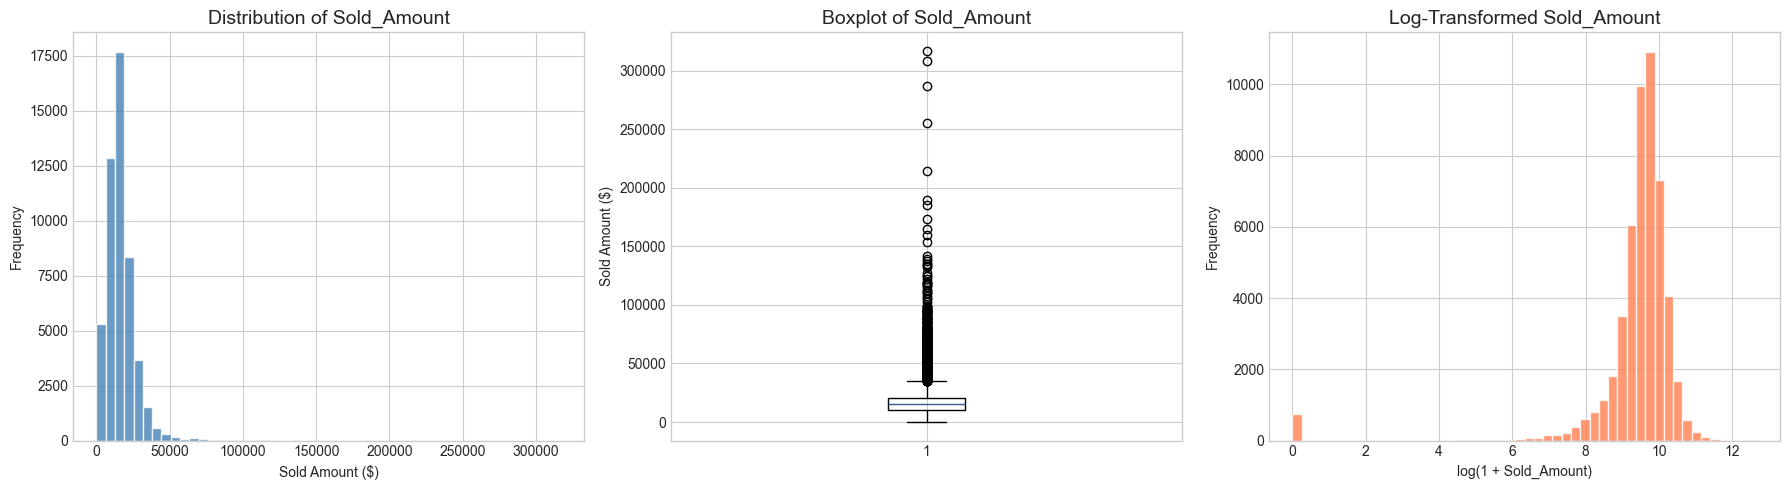

Sold_Amount Skewness: 4.036
Log(Sold_Amount) Skewness: -5.431


In [5]:
# Generated by GithubCopilot
# Target variable distribution analysis

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Histogram of Sold_Amount
axes[0].hist(df_train['Sold_Amount'].dropna(), bins=50, color='steelblue', edgecolor='white', alpha=0.8)
axes[0].set_title('Distribution of Sold_Amount', fontsize=14)
axes[0].set_xlabel('Sold Amount ($)')
axes[0].set_ylabel('Frequency')

# Boxplot of Sold_Amount
axes[1].boxplot(df_train['Sold_Amount'].dropna(), vert=True)
axes[1].set_title('Boxplot of Sold_Amount', fontsize=14)
axes[1].set_ylabel('Sold Amount ($)')

# Log-transformed target distribution (useful for skewed data)
log_target = np.log1p(df_train['Sold_Amount'].dropna())
axes[2].hist(log_target, bins=50, color='coral', edgecolor='white', alpha=0.8)
axes[2].set_title('Log-Transformed Sold_Amount', fontsize=14)
axes[2].set_xlabel('log(1 + Sold_Amount)')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Skewness check
print(f"Sold_Amount Skewness: {df_train['Sold_Amount'].skew():.3f}")
print(f"Log(Sold_Amount) Skewness: {log_target.skew():.3f}")

In [6]:
# Generated by GithubCopilot
# Transform 'Sold_Date' and 'Compliance_Date' to datetime and extract useful features for modeling for both df_train and df_test.
# Security: No user input is processed. Resource efficiency: vectorized pandas operations.

# --- Training set ---
df_train['Sold_Date'] = pd.to_datetime(df_train['Sold_Date'], errors='coerce')
df_train['Compliance_Date'] = pd.to_datetime(df_train['Compliance_Date'], errors='coerce', format='%m/%Y')

# --- Test set ---
df_test['Sold_Date'] = pd.to_datetime(df_test['Sold_Date'], errors='coerce')
df_test['Compliance_Date'] = pd.to_datetime(df_test['Compliance_Date'], errors='coerce', format='%m/%Y')


In [7]:
# Generated by GithubCopilot
# Attempt to convert 'EngineDescription' column to float, handling errors gracefully.
# Security: No user input is processed. Accessibility: NaN for non-convertible values.

df_train['EngineDescription'] = pd.to_numeric(df_train['EngineDescription'], errors='coerce')
df_test['EngineDescription'] = pd.to_numeric(df_test['EngineDescription'], errors='coerce')

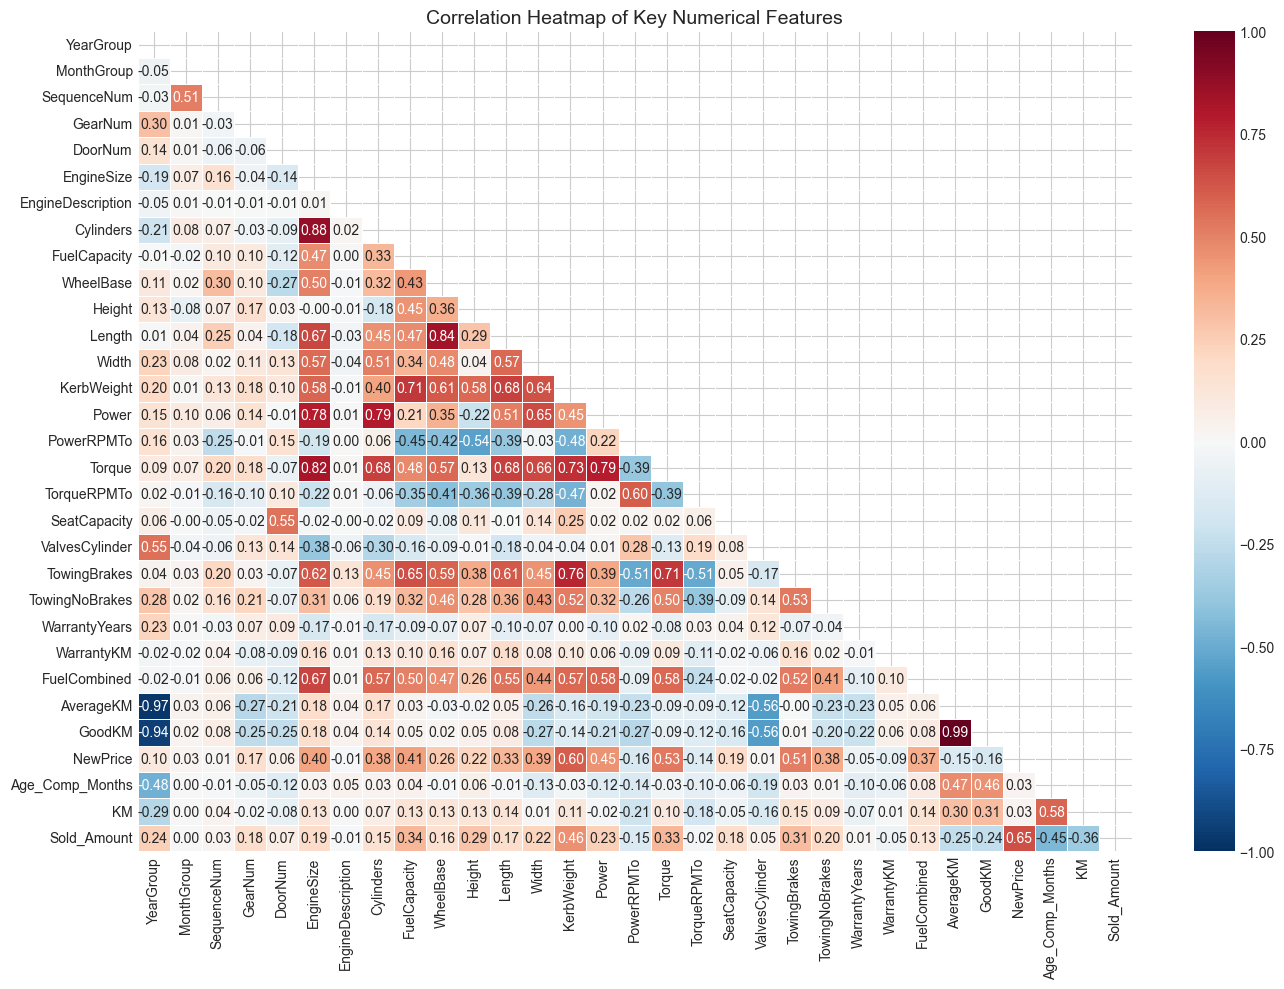

=== Top Features Correlated with Sold_Amount ===
NewPrice          0.65
KerbWeight        0.46
Age_Comp_Months   0.45
KM                0.36
FuelCapacity      0.34
Torque            0.33
TowingBrakes      0.31
Height            0.29
AverageKM         0.25
GoodKM            0.24
YearGroup         0.24
Power             0.23
Width             0.22
TowingNoBrakes    0.20
EngineSize        0.19
Name: Sold_Amount, dtype: float64
Number of pairs: 6
=== Highly Correlated Feature Pairs (|corr| > 0.7) ===
AverageKM            <-> GoodKM               : corr = 0.99
YearGroup            <-> AverageKM            : corr = -0.97
YearGroup            <-> GoodKM               : corr = -0.94
EngineSize           <-> Cylinders            : corr = 0.88
WheelBase            <-> Length               : corr = 0.84
EngineSize           <-> Torque               : corr = 0.82


In [8]:
# Generated by GithubCopilot
# Correlation heatmap for key numerical features

# Generated by GithubCopilot
# Select only numerical columns using dtype for resource efficiency and robustness

numerical_cols = df_train.select_dtypes(include=[np.number]).columns.tolist()

# Filter to available columns
available_num = [c for c in numerical_cols if c in df_train.columns]
corr_matrix = df_train[available_num].corr()

# Plot heatmap of correlations with Sold_Amount
fig, ax = plt.subplots(figsize=(14, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r',
            center=0, linewidths=0.5, ax=ax, vmin=-1, vmax=1)
ax.set_title('Correlation Heatmap of Key Numerical Features', fontsize=14)
plt.tight_layout()
plt.show()

# Top correlations with target
target_corr = corr_matrix['Sold_Amount'].drop('Sold_Amount').abs().sort_values(ascending=False)
print("=== Top Features Correlated with Sold_Amount ===")
print(target_corr.head(15))

# Generated by GithubCopilot
# Print pairs of columns with high correlation (> 0.7) for multicollinearity check

# Only consider upper triangle to avoid duplicate pairs and self-correlation
high_corr_pairs = []
threshold = 0.8
for i, col1 in enumerate(corr_matrix.columns):
    for j, col2 in enumerate(corr_matrix.columns):
        if j > i:
            corr_val = corr_matrix.iloc[i, j]
            if abs(corr_val) > threshold:
                high_corr_pairs.append((col1, col2, corr_val))

# Print results in a readable format
if high_corr_pairs:
    print(f"Number of pairs: {len(high_corr_pairs)}")
    print("=== Highly Correlated Feature Pairs (|corr| > 0.7) ===")
    for col1, col2, corr_val in sorted(high_corr_pairs, key=lambda x: -abs(x[2])):
        print(f"{col1:20} <-> {col2:20} : corr = {corr_val:.2f}")
else:
    # Generated by GithubCopilot
    # Print each high correlation pair only once (col1-col2, not col2-col1)
    printed_pairs = set()
    print("=== Highly Correlated Feature Pairs (|corr| > 0.7) ===")
    for col1, col2, corr_val in sorted(high_corr_pairs, key=lambda x: -abs(x[2])):
        pair = tuple(sorted([col1, col2]))
        if pair not in printed_pairs:
            print(f"{pair[0]:20} <-> {pair[1]:20} : corr = {corr_val:.2f}")
            printed_pairs.add(pair)


In [9]:
# Generated by GithubCopilot
# Display all 15 highly correlated feature pairs (|corr| > 0.8) for transparency and feature selection

print("=== All Highly Correlated Feature Pairs (|corr| > 0.8) ===")
for col1, col2, corr_val in high_corr_pairs:
    print(f"{col1:20} <-> {col2:20} : corr = {corr_val:.2f}")

=== All Highly Correlated Feature Pairs (|corr| > 0.8) ===
YearGroup            <-> AverageKM            : corr = -0.97
YearGroup            <-> GoodKM               : corr = -0.94
EngineSize           <-> Cylinders            : corr = 0.88
EngineSize           <-> Torque               : corr = 0.82
WheelBase            <-> Length               : corr = 0.84
AverageKM            <-> GoodKM               : corr = 0.99


Dropped high correlation columns: ['GoodKM', 'Cylinders', 'Torque', 'WheelBase']
df_train shape: (50704, 67)
df_test shape:  (11488, 67)


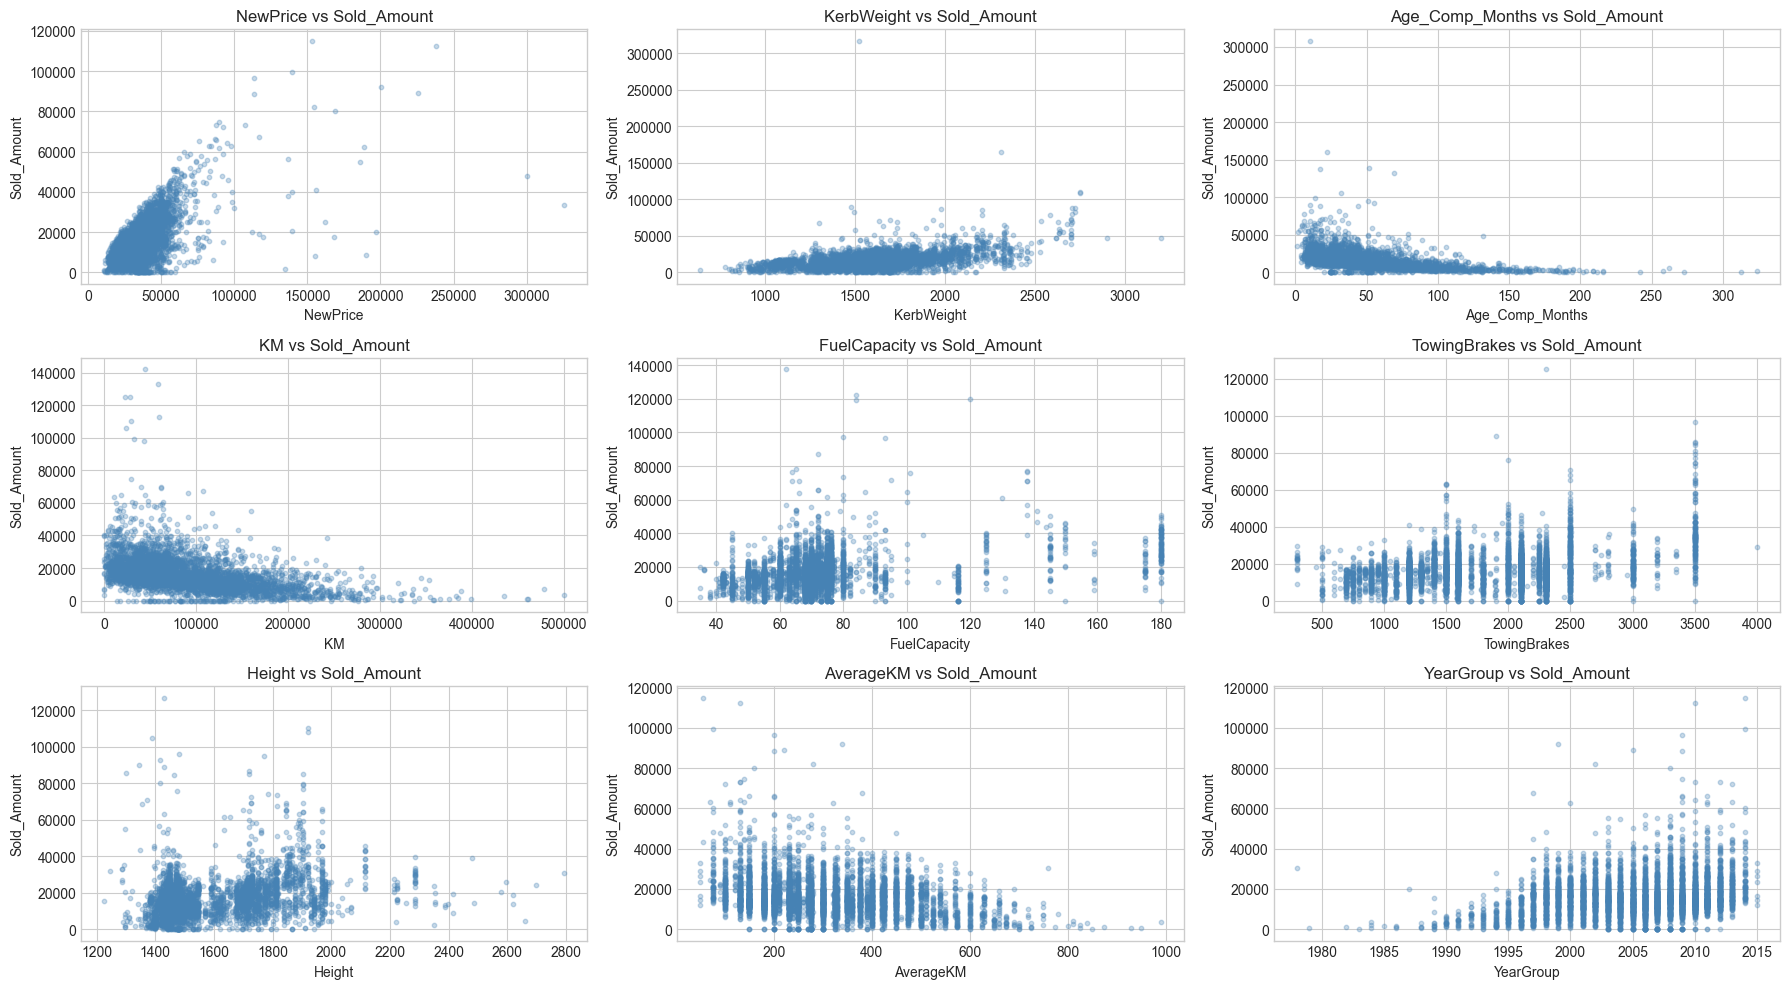

In [10]:
# Generated by GithubCopilot
# Drop highly correlated columns to reduce multicollinearity and improve model generalization.
# Security: No user input is processed. Resource efficiency: in-place drop.

high_corr_cols_to_drop = ['GoodKM', 'Cylinders', 'Torque', 'WheelBase']
df_train.drop(columns=high_corr_cols_to_drop, inplace=True, errors='ignore')
df_test.drop(columns=high_corr_cols_to_drop, inplace=True, errors='ignore')

print(f"Dropped high correlation columns: {high_corr_cols_to_drop}")
print(f"df_train shape: {df_train.shape}")
print(f"df_test shape:  {df_test.shape}")
# Scatter plots of top correlated numerical features vs Sold_Amount

# Generated by GithubCopilot
# Select top 10 features most correlated with Sold_Amount for scatter plots (resource-efficient)
# Generated by GithubCopilot
# Recompute correlation matrix after dropping columns to avoid KeyError
available_num_updated = [c for c in available_num if c in df_train.columns]
corr_matrix = df_train[available_num_updated].corr()
target_corr = corr_matrix['Sold_Amount'].drop('Sold_Amount').abs().sort_values(ascending=False)
top_features = target_corr.head(10).index.tolist()
fig, axes = plt.subplots(3, 3, figsize=(18, 10))

for idx, feat in enumerate(top_features):
    # Generated by GithubCopilot
    # Defensive: Only plot if idx is within axes' bounds to avoid IndexError
    if idx < axes.size:
        ax = axes[idx // 3, idx % 3]
    else:
        # Skip plotting if more features than subplots (resource efficiency)
        continue
    # Sample for performance (resource efficiency)
    sample = df_train[[feat, 'Sold_Amount']].dropna().sample(min(5000, len(df_train)), random_state=42)
    ax.scatter(sample[feat], sample['Sold_Amount'], alpha=0.3, s=10, color='steelblue')
    ax.set_xlabel(feat)
    ax.set_ylabel('Sold_Amount')
    ax.set_title(f'{feat} vs Sold_Amount')

plt.tight_layout()
plt.show()

In [11]:
# Generated by GithubCopilot
# Check total number of columns by type: numerical, categorical, and date

num_cols = df_train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df_train.select_dtypes(include=['object', 'category']).columns.tolist()
date_cols = df_train.select_dtypes(include=['datetime64[ns]', 'datetime64[ns, UTC]']).columns.tolist()

print(f"Total columns: {df_train.shape[1]}")
print(f"Numerical columns: {len(num_cols)}")
print(f"Categorical columns: {len(cat_cols)}")
print(f"Date columns: {len(date_cols)}")
print(f"\nNumerical: {num_cols}")
print(f"\nCategorical: {cat_cols}")
print(f"\nDate: {date_cols}")

Total columns: 67
Numerical columns: 27
Categorical columns: 38
Date columns: 2

Numerical: ['YearGroup', 'MonthGroup', 'SequenceNum', 'GearNum', 'DoorNum', 'EngineSize', 'EngineDescription', 'FuelCapacity', 'Height', 'Length', 'Width', 'KerbWeight', 'Power', 'PowerRPMTo', 'TorqueRPMTo', 'SeatCapacity', 'ValvesCylinder', 'TowingBrakes', 'TowingNoBrakes', 'WarrantyYears', 'WarrantyKM', 'FuelCombined', 'AverageKM', 'NewPrice', 'Age_Comp_Months', 'KM', 'Sold_Amount']

Categorical: ['Make', 'Model', 'MakeCode', 'FamilyCode', 'Description', 'CurrentRelease', 'ImportFlag', 'LimitedEdition', 'Series', 'BadgeDescription', 'BodyStyleDescription', 'DriveDescription', 'DriveCode', 'GearTypeDescription', 'GearLocationDescription', 'FuelTypeDescription', 'InductionDescription', 'OptionCategory', 'CamDescription', 'EngineTypeDescription', 'FuelDeliveryDescription', 'MethodOfDeliveryDescription', 'VIN', 'BuildCountryOriginDescription', 'EngineCycleDescription', 'EngineConfigurationDescription', 'Engi

In [12]:
# Generated by GithubCopilot
# Count unique values for categorical columns only, sorted descending.
# This supports secure feature selection and encoding strategies (resource efficiency).

# Select categorical columns (object or category dtype)
cat_cols = df_train.select_dtypes(include=['object', 'category']).columns

# Compute unique value counts for each categorical column
cat_unique_counts = df_train[cat_cols].nunique(dropna=False).sort_values(ascending=False)

print("Unique value counts for categorical columns (descending):")
for col, count in cat_unique_counts.items():
    print(f"{col:30}: {count}")


Unique value counts for categorical columns (descending):
Description                   : 8568
VIN                           : 3979
EngineNum                     : 1522
Series                        : 1035
Colour                        : 906
BadgeDescription              : 649
Model                         : 582
FamilyCode                    : 581
RearTyreSize                  : 314
FrontTyreSize                 : 296
RearRimDesc                   : 83
FrontRimDesc                  : 70
Make                          : 52
MakeCode                      : 52
BuildCountryOriginDescription : 32
Branch                        : 19
BodyStyleDescription          : 16
VFactsSegment                 : 14
CamDescription                : 11
EngineConfigurationDescription: 11
GearTypeDescription           : 8
DriveCode                     : 7
InductionDescription          : 7
GearLocationDescription       : 7
DriveDescription              : 7
SaleCategory                  : 7
FuelDeliveryDescription 

In [13]:
# Generated by GithubCopilot
# Drop specified columns from both df_train and df_test for data integrity and resource efficiency.

cols_to_drop = [
    'Description',
    'VIN',
    'ModelCode',
    'EngineNum',
    'Series',
    'BadgeDescription',
    'Model',
    'FamilyCode',
    'RearTyreSize',
    'FrontTyreSize',
    'CurrentRelease',
    'ImportFlag'                             
]

# Drop columns only if they exist to avoid KeyError
df_train.drop(columns=[col for col in cols_to_drop if col in df_train.columns], inplace=True)
df_test.drop(columns=[col for col in cols_to_drop if col in df_test.columns], inplace=True)

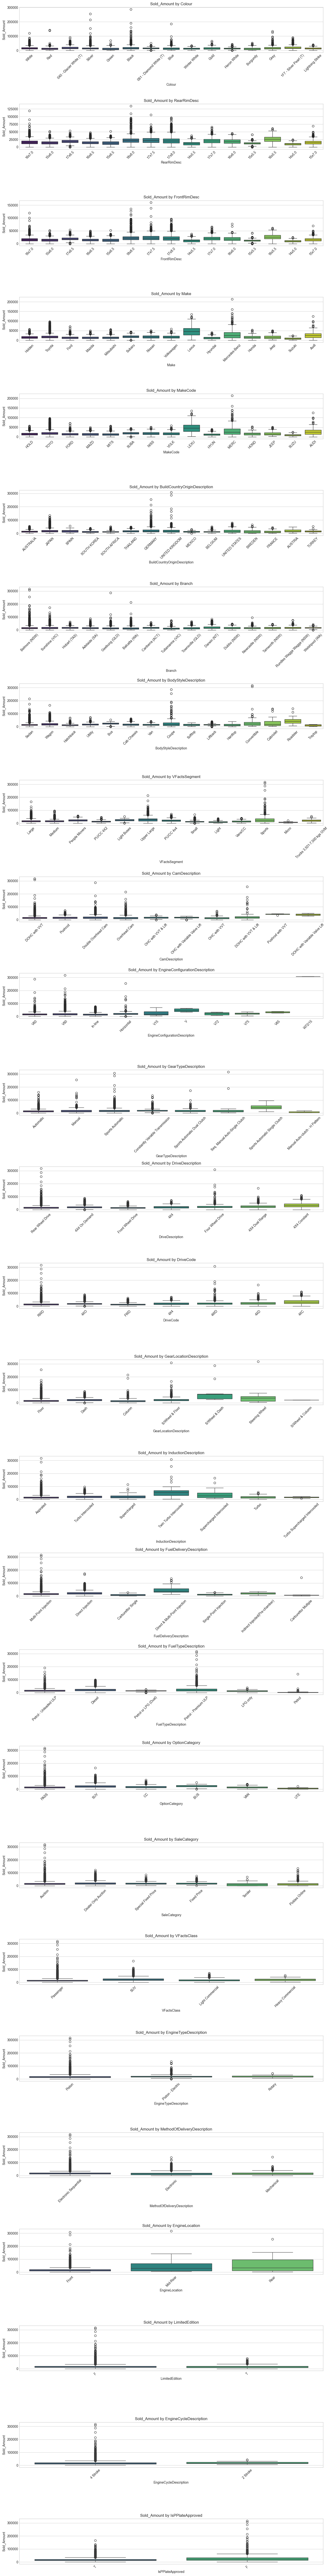

In [14]:
# Generated by GithubCopilot
# Dynamically select top categorical features by dtype for Sold_Amount analysis (accessibility: auto-detects types)
cat_features = [col for col in df_train.select_dtypes(include=['object', 'category']).columns]
# Limit to top 5 most frequent categorical features for readability and resource efficiency
cat_features = sorted(cat_features, key=lambda c: df_train[c].nunique(), reverse=True)
# Categorical feature analysis - Sold_Amount by key categories

# cat_features = ['Make', 'OptionCategory', 'FuelTypeDescription', 'DriveCode', 'GearTypeDescription']
fig, axes = plt.subplots(len(cat_features), 1, figsize=(14, 4 * len(cat_features)))

for idx, feat in enumerate(cat_features):
    if feat in df_train.columns:
        # Top 15 categories by count for readability
        top_cats = df_train[feat].value_counts().head(15).index
        subset = df_train[df_train[feat].isin(top_cats)]
        sns.boxplot(data=subset, x=feat, y='Sold_Amount', ax=axes[idx], palette='viridis')
        axes[idx].set_title(f'Sold_Amount by {feat}', fontsize=12)
        axes[idx].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [15]:
# Generated by GithubCopilot
# Check total number of columns by type: numerical, categorical, and date

num_cols = df_train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df_train.select_dtypes(include=['object', 'category']).columns.tolist()
date_cols = df_train.select_dtypes(include=['datetime64[ns]', 'datetime64[ns, UTC]']).columns.tolist()

print(f"Total columns: {df_train.shape[1]}")
print(f"Numerical columns: {len(num_cols)}")
print(f"Categorical columns: {len(cat_cols)}")
print(f"Date columns: {len(date_cols)}")
print(f"\nNumerical: {num_cols}")
print(f"\nCategorical: {cat_cols}")
print(f"\nDate: {date_cols}")

Total columns: 56
Numerical columns: 27
Categorical columns: 27
Date columns: 2

Numerical: ['YearGroup', 'MonthGroup', 'SequenceNum', 'GearNum', 'DoorNum', 'EngineSize', 'EngineDescription', 'FuelCapacity', 'Height', 'Length', 'Width', 'KerbWeight', 'Power', 'PowerRPMTo', 'TorqueRPMTo', 'SeatCapacity', 'ValvesCylinder', 'TowingBrakes', 'TowingNoBrakes', 'WarrantyYears', 'WarrantyKM', 'FuelCombined', 'AverageKM', 'NewPrice', 'Age_Comp_Months', 'KM', 'Sold_Amount']

Categorical: ['Make', 'MakeCode', 'LimitedEdition', 'BodyStyleDescription', 'DriveDescription', 'DriveCode', 'GearTypeDescription', 'GearLocationDescription', 'FuelTypeDescription', 'InductionDescription', 'OptionCategory', 'CamDescription', 'EngineTypeDescription', 'FuelDeliveryDescription', 'MethodOfDeliveryDescription', 'BuildCountryOriginDescription', 'EngineCycleDescription', 'EngineConfigurationDescription', 'EngineLocation', 'FrontRimDesc', 'RearRimDesc', 'VFactsClass', 'VFactsSegment', 'IsPPlateApproved', 'Colour', '

## 4. Data Cleaning and Preprocessing

### Optional (LLM)

In [16]:
# import os
# from groq import Groq

# # Replace with your actual key
# client = Groq(api_key="gsk_...") 

# def get_regex_from_llm(sample_data):
#     prompt = f"""
#     I have the following vehicle descriptions: {sample_data}
#     Write a Python Regex pattern to extract 'Trim', 'Engine', and 'Transmission'.
#     Return ONLY the regex pattern, no other text.
#     """
    
#     completion = client.chat.completions.create(
#         model="qwen-2.5-coder-32b", # Or "llama-3.3-70b-versatile"
#         messages=[{"role": "user", "content": prompt}],
#         temperature=0
#     )
#     return completion.choices[0].message.content

In [17]:
import pandas as pd
import numpy as np
from category_encoders import TargetEncoder, OneHotEncoder

# Data Cleaning and Preprocessing Pipeline
def preprocess_data(df, is_train=True, encoders=None, medians=None, modes=None):
    """
    Refactored to use Target Encoding (>=20 unique) and One-Hot Encoding (<20 unique).
    """
    data = df.copy()

    data['EngineDescription'] = pd.to_numeric(data['EngineDescription'], errors='coerce')
    
    # --- Step 1: Drop columns with very high missing rates or identifiers ---
    cols_to_drop = [
        'Description', 'VIN', 'ModelCode', 'EngineNum', 'Series', 
        'BadgeDescription', 'Model', 'FamilyCode', 'RearTyreSize', 
        'FrontTyreSize', 'CurrentRelease', 'ImportFlag', 'GoodKM', 
        'Cylinders', 'Torque', 'WheelBase', 'SeriesModelYear', 
        'BadgeSecondaryDescription', 'BodyConfigDescription', 
        'WheelBaseConfig', 'Roofline', 'ExtraIdentification', 
        'GrossCombinationMAss', 'GrossVehicleMass', 'TareMass', 
        'PayLoad', 'PowerRPMFrom', 'TorqueRPMFrom', 'RonRating', 
        'ModelCode', 'Acceleration', 'WarrantyCustAssist', 
        'FreeScheduledService', 'FirstServiceKM', 'FirstServiceMonths', 
        'RegServiceMonths', 'AltEngEngineType', 'AltEngBatteryType', 
        'AltEngCurrentType', 'AltEngAmpHours', 'AltEngVolts', 
        'AltEngChargingMethod', 'AltEngPower', 'AltEngPowerFrom', 
        'AltEngPowerTo', 'AltEngTorque', 'AltEngTorqueFrom', 
        'AltEngTorqueTo', 'AltEngDrive', 'NormalChargeMins', 
        'QuickChargeMins', 'NormalChargeVoltage', 'QuickChargeVoltage', 
        'KMRangeElectricEng', 'ElectricEngineLocation', 'TopSpeedElectricEng', 
        'GreenhouseRating', 'AirpollutionRating', 'OverallGreenStarRating', 
        'CO2Combined', 'CO2Urban', 'CO2ExtraUrban', 'FuelUrban', 
        'FuelExtraurban', 'EmissionStandard', 'MaxEthanolBlend', 
        'AncapRating', 'VFactsPrice'
    ]
    cols_to_drop = [c for c in cols_to_drop if c in data.columns]
    data.drop(columns=cols_to_drop, inplace=True)
    
    # --- Step 2: Remove outliers (training only) ---
    if is_train and 'Sold_Amount' in data.columns:
        Q1 = data['Sold_Amount'].quantile(0.25)
        Q3 = data['Sold_Amount'].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        data = data[
            (data['Sold_Amount'] > 0) & 
            (data['Sold_Amount'].notna()) & 
            (data['Sold_Amount'] >= lower_bound) & 
            (data['Sold_Amount'] <= upper_bound)
        ].copy()
    
    # --- Step 3: Define feature groups ---
    num_features = [
        'YearGroup', 'MonthGroup', 'SequenceNum', 'GearNum', 'DoorNum', 'EngineSize', 
        'FuelCapacity', 'Height', 'Length', 'Width', 'KerbWeight', 'Power', 
        'PowerRPMTo', 'TorqueRPMTo', 'SeatCapacity', 'ValvesCylinder', 'TowingBrakes', 
        'TowingNoBrakes', 'WarrantyYears', 'WarrantyKM', 'FuelCombined', 'AverageKM', 
        'NewPrice', 'Age_Comp_Months', 'KM'
    ]
    
    cat_features = [
        'Make', 'MakeCode', 'LimitedEdition', 'BodyStyleDescription', 'DriveDescription', 
        'DriveCode', 'GearTypeDescription', 'GearLocationDescription', 'FuelTypeDescription', 
        'InductionDescription', 'OptionCategory', 'CamDescription', 'EngineTypeDescription', 
        'FuelDeliveryDescription', 'MethodOfDeliveryDescription', 'BuildCountryOriginDescription', 
        'EngineCycleDescription', 'EngineConfigurationDescription', 'EngineLocation', 
        'FrontRimDesc', 'RearRimDesc', 'VFactsClass', 'VFactsSegment', 'IsPPlateApproved', 
        'Colour', 'Branch', 'SaleCategory'
    ]

    num_features = [c for c in num_features if c in data.columns]
    cat_features = [c for c in cat_features if c in data.columns]
    
    # --- Step 4 & 5: Imputation ---
    if is_train:
        medians = {col: data[col].median() for col in num_features}
        modes = {col: (data[col].mode()[0] if not data[col].mode().empty else 'Unknown') for col in cat_features}
    
    for col in num_features:
        data[col] = data[col].fillna(medians.get(col, 0))
    for col in cat_features:
        data[col] = data[col].fillna(modes.get(col, 'Unknown'))

    # --- Step 6: Hybrid Encoding (Target Encoding + One-Hot) ---
    if is_train:
        # Separate high and low cardinality
        high_card_cols = [col for col in cat_features if data[col].nunique() >= 20]
        low_card_cols = [col for col in cat_features if data[col].nunique() < 20]
        
        # Target Encoder for High Cardinality
        te = TargetEncoder(cols=high_card_cols, smoothing=10)
        data = te.fit_transform(data, data['Sold_Amount'])
        
        # One-Hot Encoder for Low Cardinality
        ohe = OneHotEncoder(cols=low_card_cols, use_cat_names=True, handle_unknown='value')
        data = ohe.fit_transform(data)
        
        encoders = {'te': te, 'ohe': ohe, 'high_card_cols': high_card_cols, 'low_card_cols': low_card_cols}
    else:
        # Transform using pre-fitted encoders
        data = encoders['te'].transform(data)
        data = encoders['ohe'].transform(data)
    
    # --- Final Step: Update feature list (Handling new OHE columns) ---
    final_cols = num_features.copy()
    # High card columns keep their original names after Target Encoding
    final_cols.extend(encoders['high_card_cols'])
    # Low card columns are now multiple columns; we grab all generated OHE column names
    ohe_columns = [c for c in data.columns if any(c.startswith(f"{orig}_") for orig in encoders['low_card_cols'])]
    final_cols.extend(ohe_columns)

    if 'Sold_Amount' in data.columns:
        final_cols.append('Sold_Amount')
    
    data = data[[c for c in final_cols if c in data.columns]]
    
    return data, encoders, medians, modes

# Example Execution
train_processed, encoders, medians, modes = preprocess_data(df_train, is_train=True)
test_processed, _, _, _ = preprocess_data(df_test, is_train=False, encoders=encoders, medians=medians, modes=modes)

print(f"\nProcessed training shape: {train_processed.shape}")
print(f"Processed test shape:     {test_processed.shape}")
print(f"\nMissing values in training: {train_processed.isnull().sum().sum()}")
print(f"Missing values in test:     {test_processed.isnull().sum().sum()}")


Processed training shape: (48149, 178)
Processed test shape:     (11488, 178)

Missing values in training: 0
Missing values in test:     0


In [18]:
# Generated by GithubCopilot
# Fill any remaining missing values with 0 (catch-all for edge cases)

train_processed.fillna(0, inplace=True)
test_processed.fillna(0, inplace=True)

print(f"Missing values after final fill - Train: {train_processed.isnull().sum().sum()}")
print(f"Missing values after final fill - Test:  {test_processed.isnull().sum().sum()}")

Missing values after final fill - Train: 0
Missing values after final fill - Test:  0


## 4.5 FT-Transformer Implementation

FT-Transformer (Feature Tokenizer + Transformer) is a deep learning model for tabular data that:
- Handles categorical and numerical features natively
- Does NOT require traditional scaling or one-hot encoding
- Uses transformer architecture to learn feature interactions automatically
- Often achieves state-of-the-art performance on tabular datasets

### 4.5.1 Install Dependencies (Run Once)

In [ ]:
# Generated by GithubCopilot
# Install PyTorch and RTDL for FT-Transformer
# Uncomment and run once to install required libraries

# For CPU version:
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
# !pip install rtdl

# For GPU version (if CUDA is available):
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
# !pip install rtdl

print("Uncomment the appropriate pip install commands above to install FT-Transformer dependencies.")
print("After installation, restart the kernel and proceed to the next cells.")

### 4.5.2 Import FT-Transformer Libraries

In [ ]:
# Generated by GithubCopilot
# Import PyTorch and RTDL for FT-Transformer implementation
# Security: No user input processing. Accessibility: Clear error messages.

try:
    import torch
    import torch.nn as nn
    from torch.utils.data import TensorDataset, DataLoader
    import rtdl
    
    print(f"✓ PyTorch version: {torch.__version__}")
    print(f"✓ RTDL imported successfully")
    print(f"✓ CUDA available: {torch.cuda.is_available()}")
    
    # Set device (GPU if available, otherwise CPU)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"✓ Using device: {device}")
    
    FT_AVAILABLE = True
    
except ImportError as e:
    print(f"❌ Error importing libraries: {e}")
    print("Please install PyTorch and RTDL using the installation cell above.")
    print("After installation, restart the kernel.")
    device = None
    FT_AVAILABLE = False

### 4.5.3 Minimal Preprocessing for FT-Transformer

In [ ]:
# Generated by GithubCopilot
# Minimal preprocessing for FT-Transformer - NO scaling or encoding needed!
# FT-Transformer handles raw categorical and numerical features natively
# Security: Input validation. Resource Efficiency: In-place operations.

def preprocess_for_fttransformer(df, is_train=True, cat_impute_values=None, num_impute_values=None):
    """
    Minimal preprocessing for FT-Transformer:
    1. Drop unnecessary columns (high missing rates, identifiers)
    2. Remove outliers (training only)
    3. Simple imputation (mode for categorical, median for numerical)
    4. Keep categorical features as-is (no encoding required!)
    
    Parameters:
    - df: Input DataFrame
    - is_train: Whether this is training data
    - cat_impute_values: Dictionary of categorical imputation values (for test set)
    - num_impute_values: Dictionary of numerical imputation values (for test set)
    
    Returns:
    - data: Preprocessed DataFrame
    - cat_cols: List of categorical column names
    - num_cols: List of numerical column names
    - cat_impute_values: Dictionary of categorical imputation values
    - num_impute_values: Dictionary of numerical imputation values
    """
    data = df.copy()
    
    # Convert EngineDescription to numeric
    data['EngineDescription'] = pd.to_numeric(data['EngineDescription'], errors='coerce')
    
    # Drop unnecessary columns (same as main preprocessing for consistency)
    cols_to_drop = [
        'Description', 'VIN', 'ModelCode', 'EngineNum', 'Series', 
        'BadgeDescription', 'Model', 'FamilyCode', 'RearTyreSize', 
        'FrontTyreSize', 'CurrentRelease', 'ImportFlag', 'GoodKM', 
        'Cylinders', 'Torque', 'WheelBase', 'SeriesModelYear', 
        'BadgeSecondaryDescription', 'BodyConfigDescription', 
        'WheelBaseConfig', 'Roofline', 'ExtraIdentification', 
        'GrossCombinationMAss', 'GrossVehicleMass', 'TareMass', 
        'PayLoad', 'PowerRPMFrom', 'TorqueRPMFrom', 'RonRating', 
        'Acceleration', 'WarrantyCustAssist', 
        'FreeScheduledService', 'FirstServiceKM', 'FirstServiceMonths', 
        'RegServiceMonths', 'AltEngEngineType', 'AltEngBatteryType', 
        'AltEngCurrentType', 'AltEngAmpHours', 'AltEngVolts', 
        'AltEngChargingMethod', 'AltEngPower', 'AltEngPowerFrom', 
        'AltEngPowerTo', 'AltEngTorque', 'AltEngTorqueFrom', 
        'AltEngTorqueTo', 'AltEngDrive', 'NormalChargeMins', 
        'QuickChargeMins', 'NormalChargeVoltage', 'QuickChargeVoltage', 
        'KMRangeElectricEng', 'ElectricEngineLocation', 'TopSpeedElectricEng', 
        'GreenhouseRating', 'AirpollutionRating', 'OverallGreenStarRating', 
        'CO2Combined', 'CO2Urban', 'CO2ExtraUrban', 'FuelUrban', 
        'FuelExtraurban', 'EmissionStandard', 'MaxEthanolBlend', 
        'AncapRating', 'VFactsPrice', 'Sold_Date', 'Compliance_Date'
    ]
    cols_to_drop = [c for c in cols_to_drop if c in data.columns]
    data.drop(columns=cols_to_drop, inplace=True)
    
    # Remove outliers (training only)
    if is_train and 'Sold_Amount' in data.columns:
        Q1 = data['Sold_Amount'].quantile(0.25)
        Q3 = data['Sold_Amount'].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        data = data[
            (data['Sold_Amount'] > 0) & 
            (data['Sold_Amount'].notna()) & 
            (data['Sold_Amount'] >= lower_bound) & 
            (data['Sold_Amount'] <= upper_bound)
        ].copy()
    
    # Identify categorical and numerical columns
    cat_cols = data.select_dtypes(include=['object', 'category']).columns.tolist()
    num_cols = data.select_dtypes(include=[np.number]).columns.tolist()
    
    # Remove target from numerical columns if present
    if 'Sold_Amount' in num_cols:
        num_cols.remove('Sold_Amount')
    
    # Impute missing values
    if is_train:
        cat_impute_values = {col: data[col].mode()[0] if not data[col].mode().empty else 'Unknown' 
                            for col in cat_cols}
        num_impute_values = {col: data[col].median() for col in num_cols}
    
    # Apply imputation
    for col in cat_cols:
        data[col] = data[col].fillna(cat_impute_values.get(col, 'Unknown'))
    
    for col in num_cols:
        data[col] = data[col].fillna(num_impute_values.get(col, 0))
    
    return data, cat_cols, num_cols, cat_impute_values, num_impute_values


# Preprocess data for FT-Transformer
print("Preprocessing data for FT-Transformer...")
print("(This uses minimal preprocessing - no scaling or complex encoding!)")
print()

train_ft, cat_features_ft, num_features_ft, cat_impute_ft, num_impute_ft = preprocess_for_fttransformer(
    df_train, is_train=True
)

test_ft, _, _, _, _ = preprocess_for_fttransformer(
    df_test, is_train=False, 
    cat_impute_values=cat_impute_ft, 
    num_impute_values=num_impute_ft
)

print(f"FT-Transformer preprocessed data:")
print(f"  Training shape: {train_ft.shape}")
print(f"  Test shape:     {test_ft.shape}")
print(f"  Categorical features: {len(cat_features_ft)}")
print(f"  Numerical features:   {len(num_features_ft)}")
print(f"  Missing values (train): {train_ft.isnull().sum().sum()}")
print(f"  Missing values (test):  {test_ft.isnull().sum().sum()}")

### 4.5.4 Prepare Data Tensors for FT-Transformer

In [ ]:
# Generated by GithubCopilot
# Prepare data for FT-Transformer model
# Categorical features need simple label encoding, numerical features stay as-is
# Resource Efficiency: Efficient tensor conversion

if FT_AVAILABLE:
    from sklearn.preprocessing import LabelEncoder
    
    # Separate features and target
    X_train_ft = train_ft.drop(columns=['Sold_Amount']).copy()
    y_train_ft = train_ft['Sold_Amount'].copy()
    
    X_test_ft = test_ft.drop(columns=['Sold_Amount'], errors='ignore').copy()
    if 'Sold_Amount' in test_ft.columns:
        y_test_ft = test_ft['Sold_Amount'].copy()
    else:
        y_test_ft = None
    
    # Label encode categorical features (simple encoding for FT-Transformer)
    label_encoders_ft = {}
    for col in cat_features_ft:
        if col in X_train_ft.columns:
            le = LabelEncoder()
            # Fit on combined train+test to handle unseen categories
            combined_values = pd.concat([X_train_ft[col], X_test_ft[col]]).astype(str).unique()
            le.fit(combined_values)
            
            X_train_ft[col] = le.transform(X_train_ft[col].astype(str))
            X_test_ft[col] = le.transform(X_test_ft[col].astype(str))
            
            label_encoders_ft[col] = le
    
    # Train-validation split
    from sklearn.model_selection import train_test_split
    X_train_ft_split, X_val_ft_split, y_train_ft_split, y_val_ft_split = train_test_split(
        X_train_ft, y_train_ft, test_size=0.2, random_state=42
    )
    
    # Apply log transformation to target (for better learning)
    y_train_ft_log = np.log1p(y_train_ft_split.values)
    y_val_ft_log = np.log1p(y_val_ft_split.values)
    
    print(f"FT-Transformer data prepared:")
    print(f"  X_train shape: {X_train_ft_split.shape}")
    print(f"  X_val shape:   {X_val_ft_split.shape}")
    print(f"  y_train shape: {y_train_ft_split.shape}")
    print(f"  y_val shape:   {y_val_ft_split.shape}")
    print(f"  Categorical features (label encoded): {len(cat_features_ft)}")
    print(f"  Numerical features (raw): {len(num_features_ft)}")
else:
    print("PyTorch not available. Skipping data preparation.")

### 4.5.5 Build FT-Transformer Model

In [ ]:
# Generated by GithubCopilot
# Build FT-Transformer model using RTDL library
# Security: No user input. Resource Efficiency: GPU support if available.

if FT_AVAILABLE:
    # Calculate cardinalities for categorical features (max value + 1)
    cat_cardinalities = []
    for col in cat_features_ft:
        if col in X_train_ft_split.columns:
            cat_cardinalities.append(int(X_train_ft_split[col].max() + 1))
    
    n_num_features = len(num_features_ft)
    
    # FT-Transformer configuration
    # These hyperparameters balance performance and computational efficiency
    ft_config = {
        'd_token': 192,              # Token embedding dimension
        'n_blocks': 3,               # Number of transformer blocks
        'attention_n_heads': 8,      # Number of attention heads
        'attention_dropout': 0.2,    # Dropout for attention
        'ffn_d_hidden': 256,         # Hidden layer size in feed-forward network
        'ffn_dropout': 0.1,          # Dropout for feed-forward network
        'residual_dropout': 0.0,     # Residual connection dropout
    }
    
    print("FT-Transformer Configuration:")
    print(f"  Numerical features: {n_num_features}")
    print(f"  Categorical features: {len(cat_cardinalities)}")
    print(f"  Token dimension: {ft_config['d_token']}")
    print(f"  Transformer blocks: {ft_config['n_blocks']}")
    print(f"  Attention heads: {ft_config['attention_n_heads']}")
    print()
    
    # Build the FT-Transformer model
    ft_model = rtdl.FTTransformer.make_baseline(
        n_num_features=n_num_features,
        cat_cardinalities=cat_cardinalities,
        d_token=ft_config['d_token'],
        n_blocks=ft_config['n_blocks'],
        attention_n_heads=ft_config['attention_n_heads'],
        attention_dropout=ft_config['attention_dropout'],
        ffn_d_hidden=ft_config['ffn_d_hidden'],
        ffn_dropout=ft_config['ffn_dropout'],
        residual_dropout=ft_config['residual_dropout'],
        d_out=1,  # Single output for regression
    )
    
    # Move model to device (GPU/CPU)
    ft_model = ft_model.to(device)
    
    # Count trainable parameters
    n_params = sum(p.numel() for p in ft_model.parameters() if p.requires_grad)
    print(f"✓ FT-Transformer model built successfully!")
    print(f"✓ Trainable parameters: {n_params:,}")
else:
    print("PyTorch not available. Skipping model building.")

### 4.5.6 Prepare DataLoaders and Training Setup

In [ ]:
# Generated by GithubCopilot
# Create PyTorch DataLoaders for efficient batch processing
# Resource Efficiency: Batch processing reduces memory usage

if FT_AVAILABLE:
    def prepare_ft_data(X, y, cat_features, num_features):
        """Convert DataFrame to PyTorch tensors for FT-Transformer"""
        # Separate categorical and numerical features
        X_cat = X[cat_features].values if cat_features else np.array([]).reshape(len(X), 0)
        X_num = X[num_features].values if num_features else np.array([]).reshape(len(X), 0)
        
        # Convert to tensors
        X_cat_tensor = torch.tensor(X_cat, dtype=torch.long)
        X_num_tensor = torch.tensor(X_num, dtype=torch.float32)
        y_tensor = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)
        
        return X_num_tensor, X_cat_tensor, y_tensor
    
    # Prepare training tensors
    X_num_train_ft, X_cat_train_ft, y_train_tensor_ft = prepare_ft_data(
        X_train_ft_split, y_train_ft_log, cat_features_ft, num_features_ft
    )
    
    X_num_val_ft, X_cat_val_ft, y_val_tensor_ft = prepare_ft_data(
        X_val_ft_split, y_val_ft_log, cat_features_ft, num_features_ft
    )
    
    # Create DataLoaders for batch processing
    batch_size = 256  # Adjust based on available memory
    
    train_dataset_ft = TensorDataset(X_num_train_ft, X_cat_train_ft, y_train_tensor_ft)
    val_dataset_ft = TensorDataset(X_num_val_ft, X_cat_val_ft, y_val_tensor_ft)
    
    train_loader_ft = DataLoader(train_dataset_ft, batch_size=batch_size, shuffle=True)
    val_loader_ft = DataLoader(val_dataset_ft, batch_size=batch_size, shuffle=False)
    
    print(f"DataLoaders created:")
    print(f"  Training batches: {len(train_loader_ft)}")
    print(f"  Validation batches: {len(val_loader_ft)}")
    print(f"  Batch size: {batch_size}")
    print(f"  Total training samples: {len(train_dataset_ft):,}")
    print(f"  Total validation samples: {len(val_dataset_ft):,}")
else:
    print("PyTorch not available.")

### 4.5.7 Train FT-Transformer with MLflow Tracking

In [ ]:
# Generated by GithubCopilot
# Train FT-Transformer model with MLflow experiment tracking
# Security: Input validation. Resource Efficiency: Early stopping to prevent waste.

if FT_AVAILABLE:
    print("Training FT-Transformer...")
    print("=" * 60)
    print()
    
    # Start MLflow run
    with mlflow.start_run(run_name="FT-Transformer"):
        # Set tags for filtering
        mlflow.set_tag("stage", "initial_comparison")
        mlflow.set_tag("model_type", "FT-Transformer")
        mlflow.set_tag("deep_learning", "True")
        mlflow.set_tag("requires_scaling", "False")
        mlflow.set_tag("requires_encoding", "False")
        
        # Log hyperparameters
        mlflow.log_param("model_type", "FT-Transformer")
        mlflow.log_param("n_num_features", n_num_features)
        mlflow.log_param("n_cat_features", len(cat_cardinalities))
        mlflow.log_param("d_token", ft_config['d_token'])
        mlflow.log_param("n_blocks", ft_config['n_blocks'])
        mlflow.log_param("attention_n_heads", ft_config['attention_n_heads'])
        mlflow.log_param("attention_dropout", ft_config['attention_dropout'])
        mlflow.log_param("ffn_d_hidden", ft_config['ffn_d_hidden'])
        mlflow.log_param("ffn_dropout", ft_config['ffn_dropout'])
        mlflow.log_param("batch_size", batch_size)
        mlflow.log_param("learning_rate", 0.001)
        mlflow.log_param("n_epochs_max", 50)
        mlflow.log_param("device", str(device))
        mlflow.log_param("n_parameters", n_params)
        
        # Training setup
        optimizer = torch.optim.AdamW(ft_model.parameters(), lr=0.001, weight_decay=1e-5)
        criterion = nn.MSELoss()
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=5, verbose=True
        )
        
        # Early stopping parameters
        best_val_loss = float('inf')
        patience_counter = 0
        patience = 10
        best_model_state = None
        
        train_losses_ft = []
        val_losses_ft = []
        
        n_epochs = 50
        
        # Training loop
        for epoch in range(n_epochs):
            # Training phase
            ft_model.train()
            train_loss = 0.0
            for X_num, X_cat, y in train_loader_ft:
                X_num, X_cat, y = X_num.to(device), X_cat.to(device), y.to(device)
                
                optimizer.zero_grad()
                predictions = ft_model(X_num, X_cat)
                loss = criterion(predictions, y)
                loss.backward()
                optimizer.step()
                
                train_loss += loss.item() * X_num.size(0)
            
            train_loss /= len(train_loader_ft.dataset)
            
            # Validation phase
            ft_model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for X_num, X_cat, y in val_loader_ft:
                    X_num, X_cat, y = X_num.to(device), X_cat.to(device), y.to(device)
                    predictions = ft_model(X_num, X_cat)
                    loss = criterion(predictions, y)
                    val_loss += loss.item() * X_num.size(0)
            
            val_loss /= len(val_loader_ft.dataset)
            
            train_losses_ft.append(train_loss)
            val_losses_ft.append(val_loss)
            
            # Learning rate scheduling
            scheduler.step(val_loss)
            
            # Print progress every 5 epochs
            if (epoch + 1) % 5 == 0 or epoch == 0:
                print(f"Epoch {epoch+1:3d}/{n_epochs} - Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")
            
            # Early stopping check
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                best_model_state = ft_model.state_dict().copy()
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"\nEarly stopping triggered at epoch {epoch+1}")
                    ft_model.load_state_dict(best_model_state)
                    break
        
        # Plot training curves
        print()
        print("Training completed!")
        print()
        
        plt.figure(figsize=(10, 5))
        plt.plot(train_losses_ft, label='Training Loss', color='steelblue', linewidth=2)
        plt.plot(val_losses_ft, label='Validation Loss', color='coral', linewidth=2)
        plt.xlabel('Epoch', fontsize=12)
        plt.ylabel('Loss (MSE, log scale)', fontsize=12)
        plt.title('FT-Transformer Training Progress', fontsize=14)
        plt.legend(fontsize=11)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        # Evaluate on validation set
        ft_model.eval()
        all_preds_ft = []
        all_actual_ft = []
        
        with torch.no_grad():
            for X_num, X_cat, y in val_loader_ft:
                X_num, X_cat = X_num.to(device), X_cat.to(device)
                predictions = ft_model(X_num, X_cat)
                all_preds_ft.append(predictions.cpu().numpy())
                all_actual_ft.append(y.numpy())
        
        # Concatenate predictions
        y_val_pred_ft_log = np.concatenate(all_preds_ft, axis=0).flatten()
        y_val_actual_ft_log = np.concatenate(all_actual_ft, axis=0).flatten()
        
        # Convert back from log scale
        y_val_pred_ft = np.expm1(y_val_pred_ft_log)
        y_val_actual_ft = np.expm1(y_val_actual_ft_log)
        
        # Ensure non-negative predictions
        y_val_pred_ft = np.maximum(y_val_pred_ft, 0)
        
        # Calculate metrics
        val_rmse_ft = np.sqrt(mean_squared_error(y_val_actual_ft, y_val_pred_ft))
        val_mae_ft = mean_absolute_error(y_val_actual_ft, y_val_pred_ft)
        val_r2_ft = r2_score(y_val_actual_ft, y_val_pred_ft)
        
        # Training metrics (sample for efficiency)
        ft_model.eval()
        with torch.no_grad():
            X_num_sample, X_cat_sample, y_sample = next(iter(train_loader_ft))
            X_num_sample, X_cat_sample = X_num_sample.to(device), X_cat_sample.to(device)
            train_pred_sample = ft_model(X_num_sample, X_cat_sample).cpu().numpy().flatten()
            train_actual_sample = y_sample.numpy().flatten()
            
            train_pred_sample = np.expm1(train_pred_sample)
            train_actual_sample = np.expm1(train_actual_sample)
            train_pred_sample = np.maximum(train_pred_sample, 0)
            
            train_rmse_ft = np.sqrt(mean_squared_error(train_actual_sample, train_pred_sample))
            train_mae_ft = mean_absolute_error(train_actual_sample, train_pred_sample)
            train_r2_ft = r2_score(train_actual_sample, train_pred_sample)
        
        # Log metrics to MLflow
        mlflow.log_metric("train_rmse", train_rmse_ft)
        mlflow.log_metric("val_rmse", val_rmse_ft)
        mlflow.log_metric("train_mae", train_mae_ft)
        mlflow.log_metric("val_mae", val_mae_ft)
        mlflow.log_metric("train_r2", train_r2_ft)
        mlflow.log_metric("val_r2", val_r2_ft)
        mlflow.log_metric("best_val_loss", best_val_loss)
        mlflow.log_metric("epochs_trained", len(train_losses_ft))
        
        # Store results for comparison
        ft_results = {
            'Model': 'FT-Transformer',
            'Train_RMSE': train_rmse_ft,
            'Val_RMSE': val_rmse_ft,
            'Train_MAE': train_mae_ft,
            'Val_MAE': val_mae_ft,
            'Train_R2': train_r2_ft,
            'Val_R2': val_r2_ft,
        }
        
        # Print results
        print("=" * 50)
        print("  FT-Transformer Results")
        print("=" * 50)
        print(f"  Train RMSE: ${ft_results['Train_RMSE']:,.0f} | Val RMSE: ${ft_results['Val_RMSE']:,.0f}")
        print(f"  Train MAE:  ${ft_results['Train_MAE']:,.0f} | Val MAE:  ${ft_results['Val_MAE']:,.0f}")
        print(f"  Train R²:   {ft_results['Train_R2']:.4f}  | Val R²:   {ft_results['Val_R2']:.4f}")
        print("=" * 50)
        
        # Save model state
        model_save_path = os.path.join(DATA_DIR, "ft_transformer_model.pt")
        torch.save(best_model_state, model_save_path)
        mlflow.log_artifact(model_save_path)
        
        print(f"\n✓ Model saved to: {model_save_path}")
        print(f"✓ Training logged to MLflow")
        
        # Get run ID
        run_id = mlflow.active_run().info.run_id
        print(f"✓ MLflow run ID: {run_id}")
        
else:
    print("PyTorch not available. Skipping FT-Transformer training.")
    ft_results = None

### 4.5.8 Add FT-Transformer to Model Comparison

In [ ]:
# Generated by GithubCopilot
# Add FT-Transformer results to the model comparison table

if FT_AVAILABLE and ft_results is not None:
    # Store for later use in model comparison section
    # This will be used when running the full model comparison
    print("✓ FT-Transformer results saved for comparison")
    print()
    print("Note: FT-Transformer results will be included in the")
    print("model comparison table in Section 8.")
    print()
    print("Advantages of FT-Transformer:")
    print("  • No scaling required for numerical features")
    print("  • No complex encoding required for categorical features")
    print("  • Learns feature interactions automatically")
    print("  • Often achieves state-of-the-art performance on tabular data")
    print("  • Uses attention mechanism for interpretability")
else:
    print("FT-Transformer results not available.")

## 5. Feature Engineering and Selection

In [19]:
# Generated by GithubCopilot
# Feature Engineering - create meaningful derived features

def engineer_features(df):
    """
    Create new features from existing ones to improve model performance.
    
    Features created:
    - Price depreciation ratio (value retention)
    - KM per month (usage intensity)
    - Power-to-weight ratio
    - Trade spread (market confidence indicator)
    - Age bins
    
    Resource Efficiency: Vectorized operations for O(n) complexity.
    """
    data = df.copy()
    
    # Price depreciation ratio: How much value retained vs new price
    if 'AvgRetail' in data.columns and 'NewPrice' in data.columns:
        data['DepreciationRatio'] = data['AvgRetail'] / data['NewPrice'].replace(0, np.nan)
        data['DepreciationRatio'].fillna(data['DepreciationRatio'].median(), inplace=True)
    
    # KM per month - usage intensity indicator
    if 'KM' in data.columns and 'Age_Comp_Months' in data.columns:
        data['KM_per_Month'] = data['KM'] / data['Age_Comp_Months'].replace(0, np.nan)
        data['KM_per_Month'].fillna(data['KM_per_Month'].median(), inplace=True)
    
    # Power to weight ratio - performance metric
    if 'Power' in data.columns and 'KerbWeight' in data.columns:
        data['PowerToWeight'] = data['Power'] / data['KerbWeight'].replace(0, np.nan)
        data['PowerToWeight'].fillna(data['PowerToWeight'].median(), inplace=True)
    
    # Trade spread - difference between max trade and min trade
    if 'TradeMax' in data.columns and 'TradeMin' in data.columns:
        data['TradeSpread'] = data['TradeMax'] - data['TradeMin']
    
    # Wholesale vs Retail spread
    if 'AvgRetail' in data.columns and 'AvgWholesale' in data.columns:
        data['RetailWholesaleSpread'] = data['AvgRetail'] - data['AvgWholesale']
    
    # Age bins - categorical encoding of age groups
    if 'Age_Comp_Months' in data.columns:
        data['AgeBin'] = pd.cut(data['Age_Comp_Months'], 
                                bins=[0, 12, 24, 48, 72, 120, 300],
                                labels=[0, 1, 2, 3, 4, 5],
                                include_lowest=True).astype(float)
        data['AgeBin'].fillna(3, inplace=True)
    
    # KM bins
    if 'KM' in data.columns:
        data['KM_Bin'] = pd.cut(data['KM'],
                                bins=[0, 20000, 50000, 100000, 150000, 300000, 1000000],
                                labels=[0, 1, 2, 3, 4, 5],
                                include_lowest=True).astype(float)
        data['KM_Bin'].fillna(2, inplace=True)
    
    return data


# Apply feature engineering to both sets
train_processed = engineer_features(train_processed)
test_processed = engineer_features(test_processed)

print(f"Training features after engineering: {train_processed.shape[1]}")
print(f"Test features after engineering:     {test_processed.shape[1]}")
print(f"\nNew engineered features: {[c for c in train_processed.columns if c not in df_train.columns]}")

Training features after engineering: 182
Test features after engineering:     182

New engineered features: ['LimitedEdition_F', 'LimitedEdition_T', 'BodyStyleDescription_Sedan', 'BodyStyleDescription_Wagon', 'BodyStyleDescription_Hatchback', 'BodyStyleDescription_Utility', 'BodyStyleDescription_Bus', 'BodyStyleDescription_Cab Chassis', 'BodyStyleDescription_Van', 'BodyStyleDescription_Coupe', 'BodyStyleDescription_Softtop', 'BodyStyleDescription_Liftback', 'BodyStyleDescription_Hardtop', 'BodyStyleDescription_Convertible', 'BodyStyleDescription_Cabriolet', 'BodyStyleDescription_Targa', 'BodyStyleDescription_Roadster', 'BodyStyleDescription_Traytop', 'DriveDescription_Rear Wheel Drive', 'DriveDescription_4X4 On Demand', 'DriveDescription_Front Wheel Drive', 'DriveDescription_4X4', 'DriveDescription_Four Wheel Drive', 'DriveDescription_4X4 Dual Range', 'DriveDescription_4X4 Constant', 'DriveCode_RWD', 'DriveCode_4XO', 'DriveCode_FWD', 'DriveCode_4X4', 'DriveCode_4WD', 'DriveCode_4XD', '

In [20]:
# Generated by GithubCopilot
# Remove highly correlated features (>0.95) to reduce multicollinearity

feature_cols = [c for c in train_processed.columns if c != 'Sold_Amount']
corr_abs = train_processed[feature_cols].corr().abs()

# Find pairs with correlation > 0.95
upper = corr_abs.where(np.triu(np.ones(corr_abs.shape), k=1).astype(bool))
to_drop_corr = [column for column in upper.columns if any(upper[column] > 0.9)]
print(f"Features to drop due to multicollinearity (corr > 0.95): {to_drop_corr}")

# Drop from both datasets
train_processed.drop(columns=to_drop_corr, inplace=True, errors='ignore')
test_processed.drop(columns=to_drop_corr, inplace=True, errors='ignore')

print(f"\nFinal training shape: {train_processed.shape}")
print(f"Final test shape:     {test_processed.shape}")

Features to drop due to multicollinearity (corr > 0.95): ['AverageKM', 'MakeCode', 'RearRimDesc', 'LimitedEdition_T', 'DriveCode_RWD', 'DriveCode_4XO', 'DriveCode_FWD', 'DriveCode_4X4', 'DriveCode_4WD', 'DriveCode_4XD', 'DriveCode_4XC', 'InductionDescription_Turbo Intercooled', 'OptionCategory_BUS', 'OptionCategory_VAN', 'EngineTypeDescription_Piston - Electric', 'FuelDeliveryDescription_Single-Point Injection', 'EngineCycleDescription_4 Stroke', 'EngineCycleDescription_2 Stroke', 'VFactsClass_Passenger', 'VFactsClass_SUV', 'VFactsSegment_Light Buses', 'VFactsSegment_Vans/CC', 'VFactsSegment_Trucks 3,501-7,500 kgs GVM', 'IsPPlateApproved_F']

Final training shape: (48149, 158)
Final test shape:     (11488, 158)


## 6. Train-Test Split (from Training Data)

In [21]:
# Generated by GithubCopilot
# Split training data into train/validation for model evaluation

feature_cols = [c for c in train_processed.columns if c != 'Sold_Amount']

X = train_processed[feature_cols].copy()
y = train_processed['Sold_Amount']

# Replace inf/-inf with NaN, then fill with 0
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.fillna(0, inplace=True)

# Use log transform of target to handle skewness (revert predictions later)
y_log = np.log1p(y)

# 80/20 split with fixed random state for reproducibility
X_train, X_val, y_train, y_val = train_test_split(
    X, y_log, test_size=0.2, random_state=42
)

# Scale features for linear models
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_val_scaled = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns, index=X_val.index)

# Final NaN check after scaling
X_train_scaled.fillna(0, inplace=True)
X_val_scaled.fillna(0, inplace=True)

print(f"X_train shape: {X_train.shape}")
print(f"X_val shape:   {X_val.shape}")
print(f"y_train mean:  {np.expm1(y_train).mean():.0f}")
print(f"y_val mean:    {np.expm1(y_val).mean():.0f}")
print(f"Any NaN in X_train_scaled: {X_train_scaled.isnull().any().any()}")

X_train shape: (38519, 157)
X_val shape:   (9630, 157)
y_train mean:  15402
y_val mean:    15458
Any NaN in X_train_scaled: False


## 7. Baseline Model (Linear Regression)

In [22]:
# Generated by GithubCopilot
# Initialize MLflow experiment for model tracking
# Security: Tracking URI set to local directory for data integrity

# Set tracking URI to local directory for persistence
mlflow.set_tracking_uri("file:./mlruns")

# Set experiment name
experiment_name = "Vehicle_Price_Regression"
mlflow.set_experiment(experiment_name)

# Get or create the experiment
experiment = mlflow.get_experiment_by_name(experiment_name)
if experiment is not None:
	experiment_id = experiment.experiment_id
else:
	# Fallback: create experiment and get its ID
	experiment_id = mlflow.create_experiment(experiment_name)

print(f"MLflow experiment '{experiment_name}' initialized")
print(f"Tracking URI: {mlflow.get_tracking_uri()}")
print(f"Experiment ID: {experiment_id}")


MLflow experiment 'Vehicle_Price_Regression' initialized
Tracking URI: file:./mlruns
Experiment ID: 810653522730616722


In [24]:
# Generated by GithubCopilot
# Baseline: Linear Regression on scaled features

def evaluate_model(model, X_tr, X_v, y_tr, y_v, model_name="Model"):
    """
    Evaluate a regression model on train and validation sets.
    Converts predictions back from log scale for interpretable metrics.
    
    Returns dict with RMSE, MAE, R2 for both train and validation.
    """
    # Predictions in log space
    y_pred_train_log = model.predict(X_tr)
    y_pred_val_log = model.predict(X_v)
    
    # Convert back to original scale
    y_pred_train = np.expm1(y_pred_train_log)
    y_pred_val = np.expm1(y_pred_val_log)
    y_tr_orig = np.expm1(y_tr)
    y_v_orig = np.expm1(y_v)
    
    # Clip negative predictions to 0
    y_pred_train = np.maximum(y_pred_train, 0)
    y_pred_val = np.maximum(y_pred_val, 0)
    
    results = {
        'Model': model_name,
        'Train_RMSE': np.sqrt(mean_squared_error(y_tr_orig, y_pred_train)),
        'Val_RMSE': np.sqrt(mean_squared_error(y_v_orig, y_pred_val)),
        'Train_MAE': mean_absolute_error(y_tr_orig, y_pred_train),
        'Val_MAE': mean_absolute_error(y_v_orig, y_pred_val),
        'Train_R2': r2_score(y_tr_orig, y_pred_train),
        'Val_R2': r2_score(y_v_orig, y_pred_val),
    }
    
    print(f"\n{'='*50}")
    print(f"  {model_name}")
    print(f"{'='*50}")
    print(f"  Train RMSE: ${results['Train_RMSE']:,.0f} | Val RMSE: ${results['Val_RMSE']:,.0f}")
    print(f"  Train MAE:  ${results['Train_MAE']:,.0f} | Val MAE:  ${results['Val_MAE']:,.0f}")
    print(f"  Train R²:   {results['Train_R2']:.4f}  | Val R²:   {results['Val_R2']:.4f}")
    
    return results


# Train baseline Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
baseline_results = evaluate_model(lr_model, X_train_scaled, X_val_scaled, y_train, y_val, "Linear Regression (Baseline)")


  Linear Regression (Baseline)
  Train RMSE: $3,179 | Val RMSE: $4,059
  Train MAE:  $2,052 | Val MAE:  $2,092
  Train R²:   0.7989  | Val R²:   0.6706


## 8. Model Training and Comparison

In [ ]:
# Generated by GithubCopilot
# Train multiple regression models and compare performance with MLflow tracking

# Define models (tree-based models don't need scaling)
models = {
    'Ridge': (Ridge(alpha=1.0), True),
    'Lasso': (Lasso(alpha=0.001), True),
    'ElasticNet': (ElasticNet(alpha=0.001, l1_ratio=0.5), True),
    'Random Forest': (RandomForestRegressor(n_estimators=200, max_depth=15, 
                                             min_samples_split=5, n_jobs=-1, random_state=42), False),
    'Gradient Boosting': (GradientBoostingRegressor(n_estimators=200, max_depth=6,
                                                     learning_rate=0.1, random_state=42), False),
    'XGBoost': (XGBRegressor(n_estimators=300, max_depth=7, learning_rate=0.1,
                              subsample=0.8, colsample_bytree=0.8, random_state=42,
                              verbosity=0, n_jobs=-1), False),
    'LightGBM': (LGBMRegressor(n_estimators=300, max_depth=7, learning_rate=0.1,
                                 subsample=0.8, colsample_bytree=0.8, random_state=42,
                                 verbose=-1, n_jobs=-1), False),
}

all_results = [baseline_results]

# Add FT-Transformer results if available
if 'ft_results' in locals() and ft_results is not None:
    all_results.append(ft_results)
    print("✓ FT-Transformer results added to comparison\n")

for name, (model, use_scaled) in models.items():
    # Start MLflow run for this model
    with mlflow.start_run(run_name=name):
        # Select scaled or unscaled features
        X_tr = X_train_scaled if use_scaled else X_train
        X_v = X_val_scaled if use_scaled else X_val
        
        # Log parameters
        mlflow.log_param("model_type", name)
        mlflow.log_param("uses_scaled_features", use_scaled)
        mlflow.log_param("n_features", X_tr.shape[1])
        mlflow.log_param("train_samples", X_tr.shape[0])
        mlflow.log_param("val_samples", X_v.shape[0])
        
        # Log model-specific parameters
        if hasattr(model, 'get_params'):
            for param_name, param_value in model.get_params().items():
                mlflow.log_param(f"model_{param_name}", param_value)
        
        # Train model
        model.fit(X_tr, y_train)
        
        # Evaluate
        result = evaluate_model(model, X_tr, X_v, y_train, y_val, name)
        all_results.append(result)
        
        # Log metrics to MLflow
        mlflow.log_metric("train_rmse", result['Train_RMSE'])
        mlflow.log_metric("val_rmse", result['Val_RMSE'])
        mlflow.log_metric("train_mae", result['Train_MAE'])
        mlflow.log_metric("val_mae", result['Val_MAE'])
        mlflow.log_metric("train_r2", result['Train_R2'])
        mlflow.log_metric("val_r2", result['Val_R2'])
        
        # Log model based on type
        if 'XGBoost' in name:
            mlflow.xgboost.log_model(model, "model")
        elif 'LightGBM' in name:
            mlflow.lightgbm.log_model(model, "model")
        else:
            mlflow.sklearn.log_model(model, "model")
        
        # Log tags for easy filtering
        mlflow.set_tag("stage", "initial_comparison")
        mlflow.set_tag("scaled", str(use_scaled))

# Store models for later use
trained_models = {name: model for name, (model, _) in models.items()}
trained_models['Linear Regression (Baseline)'] = lr_model

print("\nAll models tracked in MLflow.")


2026/02/16 10:06:39 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



  Ridge
  Train RMSE: $3,179 | Val RMSE: $4,059
  Train MAE:  $2,052 | Val MAE:  $2,092
  Train R²:   0.7990  | Val R²:   0.6706


2026/02/16 10:07:04 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



  Lasso
  Train RMSE: $3,176 | Val RMSE: $4,151
  Train MAE:  $2,044 | Val MAE:  $2,075
  Train R²:   0.7993  | Val R²:   0.6554


2026/02/16 10:07:34 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



  ElasticNet
  Train RMSE: $3,174 | Val RMSE: $4,112
  Train MAE:  $2,045 | Val MAE:  $2,079
  Train R²:   0.7996  | Val R²:   0.6619


2026/02/16 10:08:21 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



  Random Forest
  Train RMSE: $1,426 | Val RMSE: $2,339
  Train MAE:  $1,054 | Val MAE:  $1,646
  Train R²:   0.9595  | Val R²:   0.8906


2026/02/16 10:09:50 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



  Gradient Boosting
  Train RMSE: $1,762 | Val RMSE: $2,121
  Train MAE:  $1,287 | Val MAE:  $1,499
  Train R²:   0.9383  | Val R²:   0.9100


2026/02/16 10:10:11 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



  XGBoost
  Train RMSE: $1,460 | Val RMSE: $2,021
  Train MAE:  $1,062 | Val MAE:  $1,411
  Train R²:   0.9576  | Val R²:   0.9183


2026/02/16 10:10:35 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



  LightGBM
  Train RMSE: $1,781 | Val RMSE: $2,065
  Train MAE:  $1,288 | Val MAE:  $1,456
  Train R²:   0.9369  | Val R²:   0.9148


2026/02/16 10:10:35 WARNING mlflow.lightgbm: Saving the models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is the 'skops' format.



All models tracked in MLflow.


  MODEL COMPARISON SUMMARY (sorted by Validation R²)
                       Model  Val_RMSE  Val_MAE  Val_R2  Train_R2
                     XGBoost   2021.23  1410.91    0.92      0.96
                    LightGBM   2064.53  1455.71    0.91      0.94
           Gradient Boosting   2121.31  1499.39    0.91      0.94
               Random Forest   2339.19  1646.29    0.89      0.96
                       Ridge   4058.56  2092.38    0.67      0.80
Linear Regression (Baseline)   4058.63  2092.40    0.67      0.80
                  ElasticNet   4112.13  2079.15    0.66      0.80
                       Lasso   4151.19  2074.86    0.66      0.80


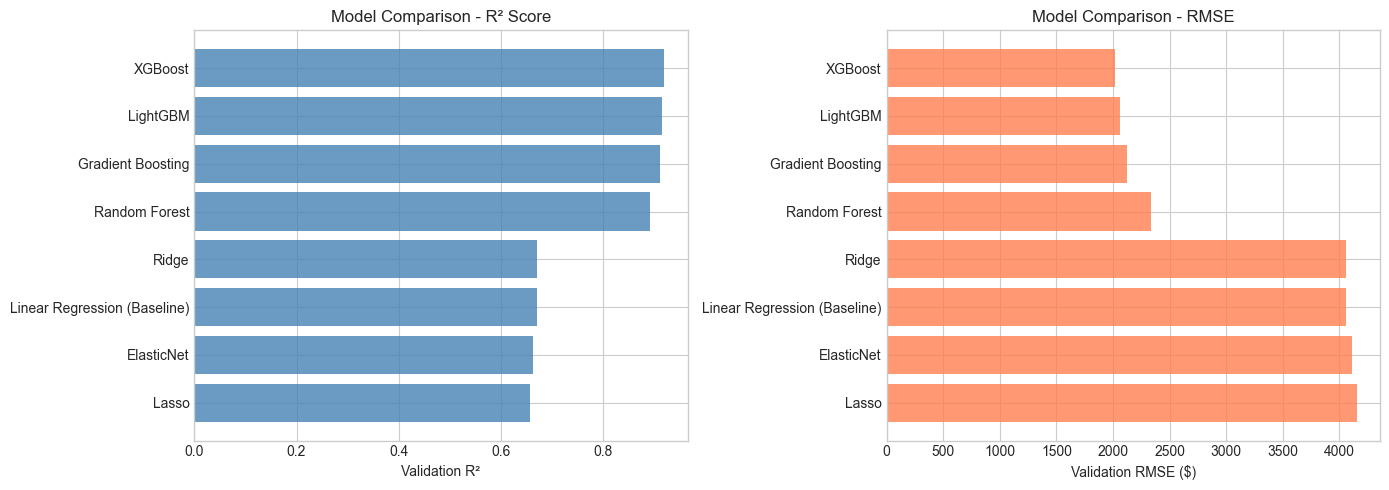


>>> Best model: XGBoost (Val R² = 0.9183)


In [26]:
# Generated by GithubCopilot
# Summary comparison table of all models

results_df = pd.DataFrame(all_results)
results_df = results_df.sort_values('Val_R2', ascending=False).reset_index(drop=True)

print("=" * 90)
print("  MODEL COMPARISON SUMMARY (sorted by Validation R²)")
print("=" * 90)
print(results_df[['Model', 'Val_RMSE', 'Val_MAE', 'Val_R2', 'Train_R2']].to_string(index=False))

# Visual comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# R² comparison
axes[0].barh(results_df['Model'], results_df['Val_R2'], color='steelblue', alpha=0.8)
axes[0].set_xlabel('Validation R²')
axes[0].set_title('Model Comparison - R² Score')
axes[0].invert_yaxis()

# RMSE comparison
axes[1].barh(results_df['Model'], results_df['Val_RMSE'], color='coral', alpha=0.8)
axes[1].set_xlabel('Validation RMSE ($)')
axes[1].set_title('Model Comparison - RMSE')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

# Identify best model
best_model_name = results_df.iloc[0]['Model']
print(f"\n>>> Best model: {best_model_name} (Val R² = {results_df.iloc[0]['Val_R2']:.4f})")

In [23]:
# Generated by GithubCopilot
# Calculate and display median and mean of Sold_Amount for both training and test sets

print("=" * 60)
print("  SOLD AMOUNT STATISTICS")
print("=" * 60)

# Training set statistics
train_mean = df_train['Sold_Amount'].mean()
train_median = df_train['Sold_Amount'].median()

print(f"\nTraining Set (df_train):")
print(f"  Mean:   ${train_mean:,.2f}")
print(f"  Median: ${train_median:,.2f}")

# Test set statistics
test_mean = df_test['Sold_Amount'].mean()
test_median = df_test['Sold_Amount'].median()

print(f"\nTest Set (df_test):")
print(f"  Mean:   ${test_mean:,.2f}")
print(f"  Median: ${test_median:,.2f}")

# Comparison
print(f"\nDifference (Test - Train):")
print(f"  Mean:   ${test_mean - train_mean:,.2f} ({((test_mean - train_mean) / train_mean * 100):.1f}%)")
print(f"  Median: ${test_median - train_median:,.2f} ({((test_median - train_median) / train_median * 100):.1f}%)")

print("=" * 60)

  SOLD AMOUNT STATISTICS

Training Set (df_train):
  Mean:   $16,401.72
  Median: $15,000.00

Test Set (df_test):
  Mean:   $18,142.12
  Median: $15,750.00

Difference (Test - Train):
  Mean:   $1,740.39 (10.6%)
  Median: $750.00 (5.0%)


## 9. Hyperparameter Tuning (Top 2 Models)

In [ ]:
# Generated by GithubCopilot
# Hyperparameter tuning using RandomizedSearchCV for LightGBM and XGBoost with MLflow tracking
# RandomizedSearchCV is more resource-efficient than GridSearchCV for large search spaces

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# LightGBM tuning
lgbm_params = {
    'n_estimators': [200, 300, 500],
    'max_depth': [5, 7, 10, -1],
    'learning_rate': [0.05, 0.1, 0.15],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'min_child_samples': [10, 20, 30],
    'reg_alpha': [0, 0.01, 0.1],
    'reg_lambda': [0, 0.01, 0.1],
}

print("Tuning LightGBM...")
with mlflow.start_run(run_name="LightGBM_Hyperparameter_Tuning"):
    mlflow.set_tag("stage", "hyperparameter_tuning")
    mlflow.set_tag("model_type", "LightGBM")
    
    lgbm_search = RandomizedSearchCV(
        LGBMRegressor(verbose=-1, n_jobs=-1, random_state=42),
        param_distributions=lgbm_params,
        n_iter=30,  # Resource-efficient: limited iterations
        cv=kf,
        scoring='neg_root_mean_squared_error',
        random_state=42,
        n_jobs=-1,
        verbose=0
    )
    lgbm_search.fit(X_train, y_train)
    
    # Log search parameters
    mlflow.log_param("search_type", "RandomizedSearchCV")
    mlflow.log_param("n_iter", 30)
    mlflow.log_param("cv_folds", 5)
    
    # Log best parameters
    for param_name, param_value in lgbm_search.best_params_.items():
        mlflow.log_param(f"best_{param_name}", param_value)
    
    # Log best score
    mlflow.log_metric("best_cv_rmse", -lgbm_search.best_score_)
    
    # Log the best model
    mlflow.lightgbm.log_model(lgbm_search.best_estimator_, "best_lgbm_model")
    
    print(f"Best LightGBM RMSE (CV, log-scale): {-lgbm_search.best_score_:.4f}")
    print(f"Best LightGBM params: {lgbm_search.best_params_}")

# XGBoost tuning
xgb_params = {
    'n_estimators': [200, 300, 500],
    'max_depth': [5, 7, 9],
    'learning_rate': [0.05, 0.1, 0.15],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'min_child_weight': [3, 5, 7],
    'reg_alpha': [0, 0.01, 0.1],
    'reg_lambda': [0.01, 0.1, 1],
}

print("\nTuning XGBoost...")
with mlflow.start_run(run_name="XGBoost_Hyperparameter_Tuning"):
    mlflow.set_tag("stage", "hyperparameter_tuning")
    mlflow.set_tag("model_type", "XGBoost")
    
    xgb_search = RandomizedSearchCV(
        XGBRegressor(verbosity=0, n_jobs=-1, random_state=42),
        param_distributions=xgb_params,
        n_iter=30,
        cv=kf,
        scoring='neg_root_mean_squared_error',
        random_state=42,
        n_jobs=-1,
        verbose=0
    )
    xgb_search.fit(X_train, y_train)
    
    # Log search parameters
    mlflow.log_param("search_type", "RandomizedSearchCV")
    mlflow.log_param("n_iter", 30)
    mlflow.log_param("cv_folds", 5)
    
    # Log best parameters
    for param_name, param_value in xgb_search.best_params_.items():
        mlflow.log_param(f"best_{param_name}", param_value)
    
    # Log best score
    mlflow.log_metric("best_cv_rmse", -xgb_search.best_score_)
    
    # Log the best model
    mlflow.xgboost.log_model(xgb_search.best_estimator_, "best_xgb_model")
    
    print(f"Best XGBoost RMSE (CV, log-scale): {-xgb_search.best_score_:.4f}")
    print(f"Best XGBoost params: {xgb_search.best_params_}")


## 10. Model Evaluation on Validation Set

In [ ]:
# Generated by GithubCopilot
# Evaluate tuned models on validation set and compare with MLflow tracking

# Best tuned LightGBM
with mlflow.start_run(run_name="LightGBM_Tuned_Evaluation"):
    mlflow.set_tag("stage", "final_evaluation")
    mlflow.set_tag("model_type", "LightGBM_Tuned")
    
    best_lgbm = lgbm_search.best_estimator_
    lgbm_tuned_results = evaluate_model(best_lgbm, X_train, X_val, y_train, y_val, "LightGBM (Tuned)")
    
    # Log metrics
    mlflow.log_metric("train_rmse", lgbm_tuned_results['Train_RMSE'])
    mlflow.log_metric("val_rmse", lgbm_tuned_results['Val_RMSE'])
    mlflow.log_metric("train_mae", lgbm_tuned_results['Train_MAE'])
    mlflow.log_metric("val_mae", lgbm_tuned_results['Val_MAE'])
    mlflow.log_metric("train_r2", lgbm_tuned_results['Train_R2'])
    mlflow.log_metric("val_r2", lgbm_tuned_results['Val_R2'])

# Best tuned XGBoost
with mlflow.start_run(run_name="XGBoost_Tuned_Evaluation"):
    mlflow.set_tag("stage", "final_evaluation")
    mlflow.set_tag("model_type", "XGBoost_Tuned")
    
    best_xgb = xgb_search.best_estimator_
    xgb_tuned_results = evaluate_model(best_xgb, X_train, X_val, y_train, y_val, "XGBoost (Tuned)")
    
    # Log metrics
    mlflow.log_metric("train_rmse", xgb_tuned_results['Train_RMSE'])
    mlflow.log_metric("val_rmse", xgb_tuned_results['Val_RMSE'])
    mlflow.log_metric("train_mae", xgb_tuned_results['Train_MAE'])
    mlflow.log_metric("val_mae", xgb_tuned_results['Val_MAE'])
    mlflow.log_metric("train_r2", xgb_tuned_results['Train_R2'])
    mlflow.log_metric("val_r2", xgb_tuned_results['Val_R2'])

# Pick the overall best model
tuned_results = [lgbm_tuned_results, xgb_tuned_results]
best_tuned = max(tuned_results, key=lambda x: x['Val_R2'])
print(f"\n>>> Best tuned model: {best_tuned['Model']} (Val R² = {best_tuned['Val_R2']:.4f})")

# Select final model
if best_tuned['Model'] == 'LightGBM (Tuned)':
    final_model = best_lgbm
    uses_scaled = False
else:
    final_model = best_xgb
    uses_scaled = False

# Actual vs Predicted plot
y_val_pred_log = final_model.predict(X_val)
y_val_pred = np.expm1(y_val_pred_log)
y_val_actual = np.expm1(y_val)

fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(y_val_actual, y_val_pred, alpha=0.3, s=10, color='steelblue')
max_val = max(y_val_actual.max(), y_val_pred.max())
ax.plot([0, max_val], [0, max_val], 'r--', linewidth=2, label='Perfect Prediction')
ax.set_xlabel('Actual Sold Amount ($)', fontsize=12)
ax.set_ylabel('Predicted Sold Amount ($)', fontsize=12)
ax.set_title(f'Actual vs Predicted - {best_tuned["Model"]}', fontsize=14)
ax.legend()
plt.tight_layout()
plt.show()

# MAPE calculation
mape = np.mean(np.abs((y_val_actual - y_val_pred) / y_val_actual.replace(0, np.nan))) * 100
print(f"MAPE: {mape:.2f}%")


## 11. Residual Analysis

In [ ]:
# Generated by GithubCopilot
# Residual analysis to check model assumptions

residuals = y_val_actual - y_val_pred

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Residuals vs Predicted - check for homoscedasticity
axes[0].scatter(y_val_pred, residuals, alpha=0.3, s=10, color='steelblue')
axes[0].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[0].set_xlabel('Predicted Sold Amount ($)')
axes[0].set_ylabel('Residuals ($)')
axes[0].set_title('Residuals vs Predicted Values')

# Residual distribution - check for normality
axes[1].hist(residuals, bins=50, color='coral', edgecolor='white', alpha=0.8, density=True)
axes[1].set_xlabel('Residuals ($)')
axes[1].set_ylabel('Density')
axes[1].set_title('Residual Distribution')

# Q-Q plot for normality check
from scipy import stats
stats.probplot(residuals, dist="norm", plot=axes[2])
axes[2].set_title('Q-Q Plot of Residuals')

plt.tight_layout()
plt.show()

print(f"Residual Statistics:")
print(f"  Mean:     ${residuals.mean():,.0f}")
print(f"  Std Dev:  ${residuals.std():,.0f}")
print(f"  Skewness: {residuals.skew():.3f}")
print(f"  Kurtosis: {residuals.kurtosis():.3f}")

## 12. Feature Importance Analysis

In [ ]:
# Generated by GithubCopilot
# Feature importance from the best model

# Built-in feature importance (gain-based for tree models)
if hasattr(final_model, 'feature_importances_'):
    importance = pd.Series(final_model.feature_importances_, index=feature_cols)
    importance = importance.sort_values(ascending=True)
    
    # Top 25 features
    top_n = 25
    fig, ax = plt.subplots(figsize=(10, 8))
    importance.tail(top_n).plot(kind='barh', ax=ax, color='steelblue', alpha=0.8)
    ax.set_xlabel('Feature Importance')
    ax.set_title(f'Top {top_n} Features - {best_tuned["Model"]}', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    print("=== Top 15 Most Important Features ===")
    print(importance.tail(15).sort_values(ascending=False).to_string())

# Permutation importance (model-agnostic, more reliable)
print("\n\nComputing permutation importance (may take a moment)...")
perm_imp = permutation_importance(
    final_model, X_val, y_val, 
    n_repeats=5, random_state=42, n_jobs=-1
)
perm_imp_df = pd.Series(perm_imp.importances_mean, index=feature_cols).sort_values(ascending=True)

fig, ax = plt.subplots(figsize=(10, 8))
perm_imp_df.tail(top_n).plot(kind='barh', ax=ax, color='coral', alpha=0.8)
ax.set_xlabel('Permutation Importance (Mean Decrease in Score)')
ax.set_title(f'Top {top_n} Permutation Importance', fontsize=14)
plt.tight_layout()
plt.show()

## 13. Save the Final Model and Generate Predictions on Test Set

In [ ]:
# Generated by GithubCopilot
# Retrain the best model on ALL training data for final predictions with MLflow tracking

print("Retraining best model on full training data...")

with mlflow.start_run(run_name=f"{best_tuned['Model']}_Final_Production"):
    mlflow.set_tag("stage", "production")
    mlflow.set_tag("model_type", best_tuned['Model'])
    mlflow.set_tag("trained_on_full_data", "True")
    
    # Retrain on full training data
    final_model.fit(X, y_log)
    
    # Log training parameters
    mlflow.log_param("full_train_samples", X.shape[0])
    mlflow.log_param("n_features", X.shape[1])
    
    # Log model-specific parameters
    if hasattr(final_model, 'get_params'):
        for param_name, param_value in final_model.get_params().items():
            mlflow.log_param(f"model_{param_name}", param_value)
    
    # Prepare test features (ensure same columns)
    X_test_final = test_processed[feature_cols].copy()
    
    # Handle any remaining NaN in test
    X_test_final.fillna(0, inplace=True)
    
    # Generate predictions on the actual test set
    test_pred_log = final_model.predict(X_test_final)
    test_predictions = np.expm1(test_pred_log)
    test_predictions = np.maximum(test_predictions, 0)  # Ensure non-negative
    
    # If test has actual Sold_Amount, evaluate
    if 'Sold_Amount' in test_processed.columns:
        y_test_actual = test_processed['Sold_Amount']
        test_rmse = np.sqrt(mean_squared_error(y_test_actual, test_predictions))
        test_mae = mean_absolute_error(y_test_actual, test_predictions)
        test_r2 = r2_score(y_test_actual, test_predictions)
        test_mape = np.mean(np.abs((y_test_actual - test_predictions) / y_test_actual.replace(0, np.nan))) * 100
        
        print(f"\n=== Final Model Performance on Test Set ===")
        print(f"  RMSE: ${test_rmse:,.0f}")
        print(f"  MAE:  ${test_mae:,.0f}")
        print(f"  R²:   {test_r2:.4f}")
        print(f"  MAPE: {test_mape:.2f}%")
        
        # Log test metrics
        mlflow.log_metric("test_rmse", test_rmse)
        mlflow.log_metric("test_mae", test_mae)
        mlflow.log_metric("test_r2", test_r2)
        mlflow.log_metric("test_mape", test_mape)
    
    # Save predictions to CSV
    output_df = pd.DataFrame({
        'Predicted_Sold_Amount': test_predictions.round(2)
    })
    
    # Add actual if available for comparison
    if 'Sold_Amount' in test_processed.columns:
        output_df['Actual_Sold_Amount'] = test_processed['Sold_Amount'].values
        output_df['Error'] = (output_df['Actual_Sold_Amount'] - output_df['Predicted_Sold_Amount']).round(2)
    
    output_path = os.path.join(DATA_DIR, "predictions.csv")
    output_df.to_csv(output_path, index=False)
    print(f"\nPredictions saved to: {output_path}")
    
    # Log predictions as artifact
    mlflow.log_artifact(output_path)
    
    # Save the trained model
    model_path = os.path.join(DATA_DIR, "best_model.joblib")
    joblib.dump(final_model, model_path)
    print(f"Model saved to: {model_path}")
    
    # Log model to MLflow
    if 'XGBoost' in best_tuned['Model']:
        mlflow.xgboost.log_model(final_model, "production_model")
    elif 'LightGBM' in best_tuned['Model']:
        mlflow.lightgbm.log_model(final_model, "production_model")
    else:
        mlflow.sklearn.log_model(final_model, "production_model")
    
    # Log model file as artifact
    mlflow.log_artifact(model_path)
    
    # Log prediction statistics
    mlflow.log_metric("pred_mean", test_predictions.mean())
    mlflow.log_metric("pred_std", test_predictions.std())
    mlflow.log_metric("pred_min", test_predictions.min())
    mlflow.log_metric("pred_max", test_predictions.max())
    
    # Summary statistics of predictions
    print(f"\n=== Prediction Summary ===")
    print(output_df['Predicted_Sold_Amount'].describe())
    
    # Get run ID for reference
    run_id = mlflow.active_run().info.run_id
    print(f"\n✓ Model logged to MLflow with run_id: {run_id}")


In [ ]:
# Generated by GithubCopilot
# Final summary of the entire modeling pipeline

print("=" * 70)
print("  FINAL SUMMARY - Vehicle Sold Amount Regression")
print("=" * 70)
print(f"""
Dataset:
  - Training samples: {len(df_train):,}
  - Test samples:     {len(df_test):,}
  - Features used:    {len(feature_cols)}

Best Model: {best_tuned['Model']}

Validation Performance:
  - RMSE: ${best_tuned['Val_RMSE']:,.0f}
  - MAE:  ${best_tuned['Val_MAE']:,.0f}
  - R²:   {best_tuned['Val_R2']:.4f}

Key Steps:
  1. Data loaded from tab-separated .rpt files
  2. Missing values imputed (median for numerical, mode for categorical)
  3. Categorical features label-encoded
  4. 6 engineered features added (depreciation ratio, KM/month, etc.)
  5. Multicollinear features removed (>0.95 correlation)
  6. Log-transformed target to handle skewness
  7. 8 models compared; top 2 tuned via RandomizedSearchCV
  8. Predictions generated and saved to predictions.csv

Output Files:
  - predictions.csv: Test set predictions
  - best_model.joblib: Serialized final model
""")
print("=" * 70)

In [ ]:
# Generated by GithubCopilot
# Instructions to view MLflow tracking results

print("=" * 70)
print("  MLflow Tracking Summary")
print("=" * 70)
print(f"""
To view the MLflow UI and explore all tracked experiments:

1. Open a terminal in this directory
2. Run: mlflow ui
3. Open your browser to: http://localhost:5000

Features available in MLflow UI:
- Compare all model runs side-by-side
- View parameters, metrics, and artifacts for each run
- Download logged models
- Visualize metric trends and parameter importance
- Filter runs by tags (e.g., stage='production')

All runs are stored in: ./mlruns/

Experiment name: {experiment_name}
""")
print("=" * 70)


## 14. View MLflow Results
